In [1]:
# %matplotlib widget
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

seaborn.set(context="notebook", style="darkgrid")
plt.rcParams["figure.figsize"] = (8, 6)
from tqdm.auto import tqdm, trange

from ssptools import evolve_mf_3 as emf3
from limepy import *
from scipy.signal import convolve
import numpy as np
import scipy
import scipy as sp
import pandas as pd
from scipy.interpolate import BPoly, interp1d, UnivariateSpline
from numpy import exp, sqrt, pi, sin, cos, log10
from scipy.special import gamma, gammainc, hyp1f1
from scipy.integrate import ode, simpson, quad
from math import factorial, sinh
import astropy.units as u
from astropy.constants import c
from astropy.table import QTable
from astropy.io import ascii

In [2]:
import fitter
from fitter.probabilities.pulsars import *

In [3]:
pulsars = QTable(ascii.read("../../47-tuc-pulsar-fitting/data/pulsars_isolated_acc.dat"))

In [4]:
pulsars

Pulsar,r_pc,P,sigma_P,Pdot,sigma_Pdot,DM,sigma_DM,a_los,sigma_a_los
str2,float64,float64,float64,float64,float64,float64,float64,float64,float64
C,1.6778,0.0057567799955164,1e-19,-4.985e-20,2.0000000000000002e-24,24.6,0.004,-2.5960092348395224e-09,1.0415282787721256e-13
D,0.8845,0.00535757328486572,7e-14,-3.4218999999999995e-21,8.999999999999998e-25,24.732,0.003,-1.9147844695434933e-10,5.036108660653865e-14
F,0.2932,0.00262357935251262,3e-17,6.45031e-20,6.9999999999999995e-25,24.382,0.005,7.370672009253352e-09,7.998794486586453e-14
G,0.3794,0.0040403791435651,1e-16,-4.2159e-20,2.0000000000000002e-24,24.436,0.004,-3.1281594592307987e-09,1.4839818113478967e-13
J,1.3895,0.00210063354535248,6e-17,-9.791899999999999e-21,8.999999999999998e-25,24.588,0.003,-1.3974535329995527e-09,1.284437320335785e-13
L,0.222,0.0043461679994616,3e-16,-1.2204059999999998e-19,1e-24,24.4,0.012,-8.418186193982181e-09,6.897857101638458e-14
M,1.4581,0.0036766432176002,3e-16,-3.8418e-20,5e-24,24.432,0.016,-3.1325929577038473e-09,4.076985993159258e-13
N,0.6539,0.0030539543462608,1e-16,-2.1857e-20,2.0000000000000002e-24,24.574,0.009,-2.1455997737912576e-09,1.9633067427288814e-13
O,0.1099,0.00264334329724356,4e-17,3.03493e-20,6e-25,24.356,0.002,3.44203919902011e-09,6.80484729272855e-14


In [5]:
pulsars["a_los"] <<= (u.m / u.s /u.s)
pulsars["r_pc"] <<= (u.pc)
pulsars["P"] <<= (u.s)

In [6]:
pulsars

Pulsar,r_pc,P,sigma_P,Pdot,sigma_Pdot,DM,sigma_DM,a_los,sigma_a_los
,pc,s,,,,,,m / s2,
str2,float64,float64,float64,float64,float64,float64,float64,float64,float64
C,1.6778,0.0057567799955164,1e-19,-4.985e-20,2.0000000000000002e-24,24.6,0.004,-2.5960092348395224e-09,1.0415282787721256e-13
D,0.8845,0.00535757328486572,7e-14,-3.4218999999999995e-21,8.999999999999998e-25,24.732,0.003,-1.9147844695434933e-10,5.036108660653865e-14
F,0.2932,0.00262357935251262,3e-17,6.45031e-20,6.9999999999999995e-25,24.382,0.005,7.370672009253352e-09,7.998794486586453e-14
G,0.3794,0.0040403791435651,1e-16,-4.2159e-20,2.0000000000000002e-24,24.436,0.004,-3.1281594592307987e-09,1.4839818113478967e-13
J,1.3895,0.00210063354535248,6e-17,-9.791899999999999e-21,8.999999999999998e-25,24.588,0.003,-1.3974535329995527e-09,1.284437320335785e-13
L,0.222,0.0043461679994616,3e-16,-1.2204059999999998e-19,1e-24,24.4,0.012,-8.418186193982181e-09,6.897857101638458e-14
M,1.4581,0.0036766432176002,3e-16,-3.8418e-20,5e-24,24.432,0.016,-3.1325929577038473e-09,4.076985993159258e-13
N,0.6539,0.0030539543462608,1e-16,-2.1857e-20,2.0000000000000002e-24,24.574,0.009,-2.1455997737912576e-09,1.9633067427288814e-13


In [7]:
m123 = [0.1, 0.5, 1.0, 100]  # Slope breakpoints for initial mass function
a12 = [-0.49, -0.56, -2.58]  # Slopes for initial mass function
nbin12 = [5, 5, 20]

# Output times for the evolution
tout = np.array(
    [
        11000,
    ]
)
# tout = np.array([11000])

# Integration settings
N0 = 5e5  # Normalization of stars
Ndot = -0.0001  # Regulates how low mass objects are depleted default -20, 0 for 47 Tuc
tcc = 0  # Core collapse time
NS_ret = 0.1  # Initial neutron star retention
BH_ret_int = 1  # Initial Black Hole retention
BH_ret_dyn = 0.00235  # Dynamical Black Hole retention
FeHe = -0.7  # Metallicity

In [8]:
f = emf3.evolve_mf(
    m123=m123,
    a12=a12,
    nbin12=nbin12,
    tout=tout,
    N0=N0,
    Ndot=Ndot,
    tcc=tcc,
    NS_ret=NS_ret,
    BH_ret_int=BH_ret_int,
    BH_ret_dyn=BH_ret_dyn,
    FeHe=FeHe,
    natal_kicks=True,
    vesc=150,
)

/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/ssptools/evolve_mf_3.py:321: RuntimeWarning: divide by zero encountered in true_divide
  As = Ns / P1


In [9]:
cs = f.Ns[-1] > 10 * f.Nmin
cr = f.Nr[-1] > 10 * f.Nmin
mj = np.r_[f.ms[-1][cs], f.mr[-1][cr]]
Mj = np.r_[f.Ms[-1][cs], f.Mr[-1][cr]]
dms = f.mes[-1][1:] - f.mes[-1][0:-1]
nms = len(f.ms[-1][cs])
# Add in bin of 1.6 MSol to use to model MSPs
mj = np.append(mj, 1.6)
Mj = np.append(Mj, 0.1)

In [10]:
%time m = limepy(phi0=6.3, g=0.84,ra = 10**1.28,mj=mj,Mj=Mj, rh=7.47,M=0.967e6,delta=0.45,verbose=False, project=True)

CPU times: user 3.92 s, sys: 1.14 ms, total: 3.92 s
Wall time: 3.92 s


In [11]:
G_units = u.Unit('(pc km2) / (s2 Msun)')
R_units = u.pc
M_units = u.Msun
V2_units = G_units * M_units / R_units

m.G <<= G_units

m.M <<= M_units
m.mj <<= M_units
m.Mj <<= M_units
m.mc <<= M_units

m.r <<= R_units
m.rh <<= R_units
m.rt <<= R_units
m.ra <<= R_units

m.v2Tj <<= V2_units
m.v2Rj <<= V2_units
m.v2pj <<= V2_units

m.rhoj <<= (M_units / R_units**3)
m.Sigmaj <<= (M_units / R_units**2)

m.d = 4.45
m.d <<= u.kpc

In [12]:
a_space = np.linspace(-20e-9, 20e-9, 5000)

/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


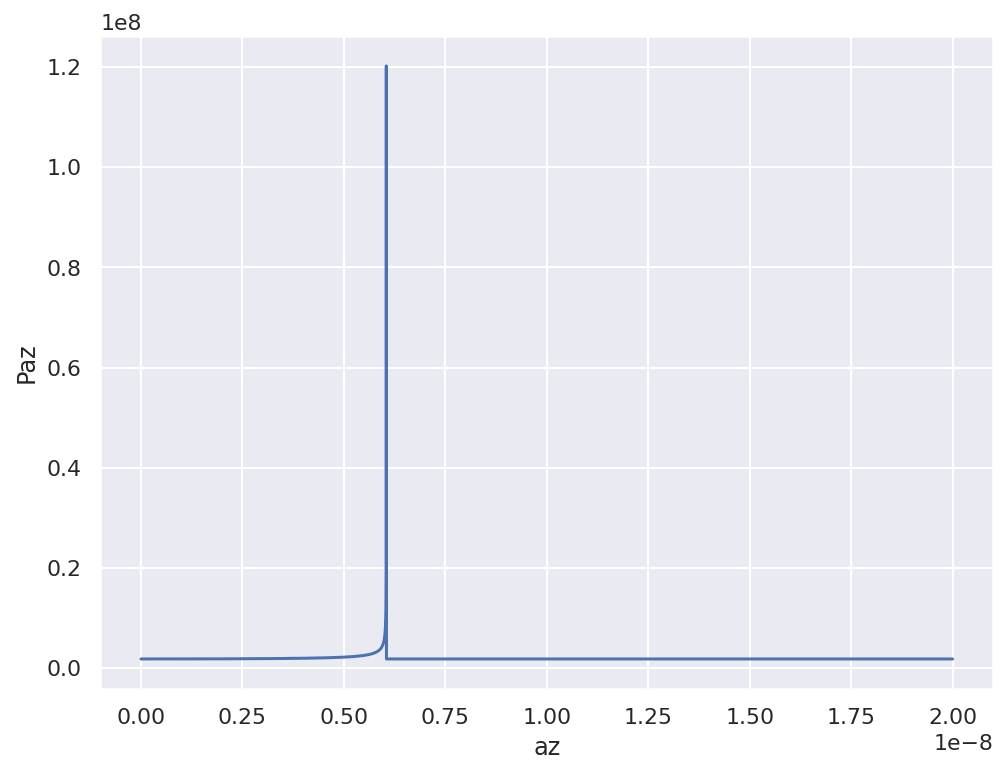

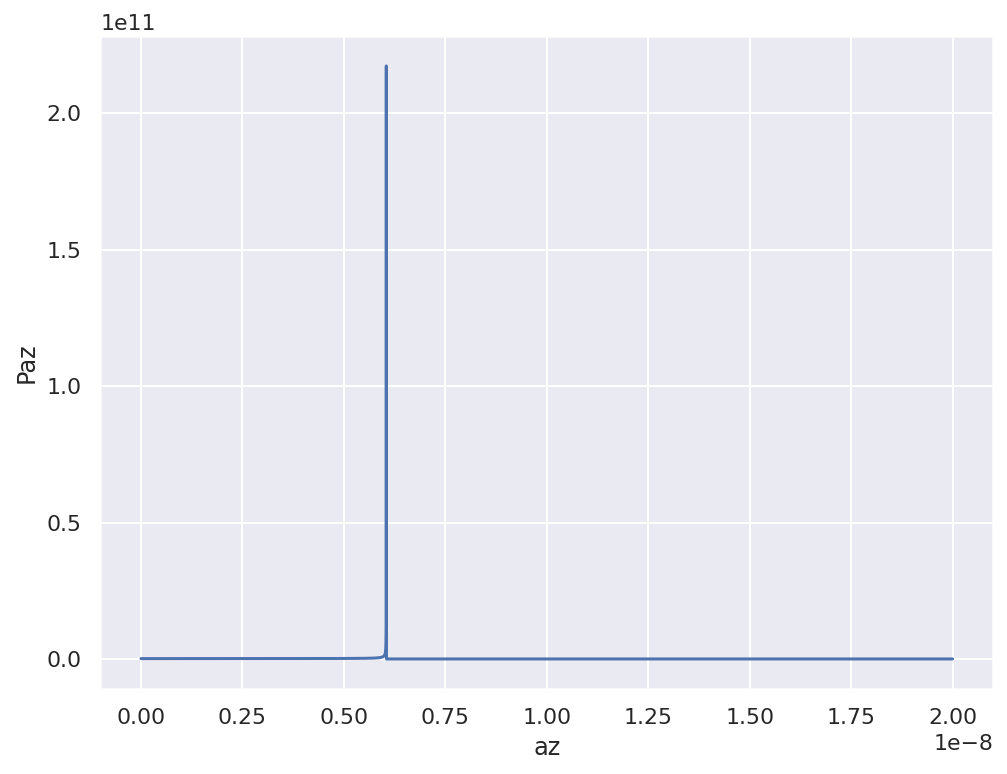

In [13]:
pdot, Paz = cluster_component(model=m, R=pulsars[1]["r_pc"],mass_bin=-1 )

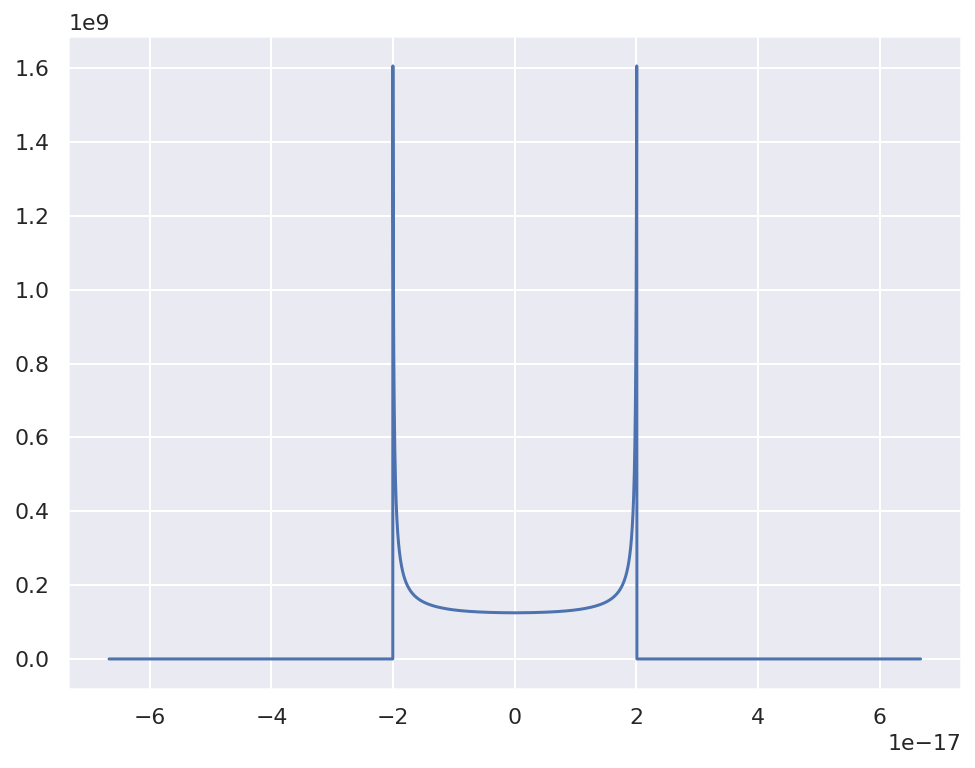

In [14]:
plt.plot(pdot, Paz)

In [15]:
# It's normalized if you add the factor of c back in

In [16]:
Paz_spl = UnivariateSpline(pdot*c,Paz)

In [17]:
Paz_spl.integral(-np.inf,np.inf)/2

0.9968240358292979

In [18]:
from fitter.probabilities import likelihood_pulsar_spin

In [19]:
# make the indexing work with local data
pulsars["r"] = pulsars["r_pc"]
pulsars["Pdot_meas"] = pulsars["Pdot"]
pulsars['ΔPdot_meas'] = pulsars["sigma_Pdot"]

/home/peter/research/GCfit/fitter/probabilities/pulsars.py:274: RuntimeWarning: invalid value encountered in log10
  Pdot_int = np.log10(Pdot_int)
/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


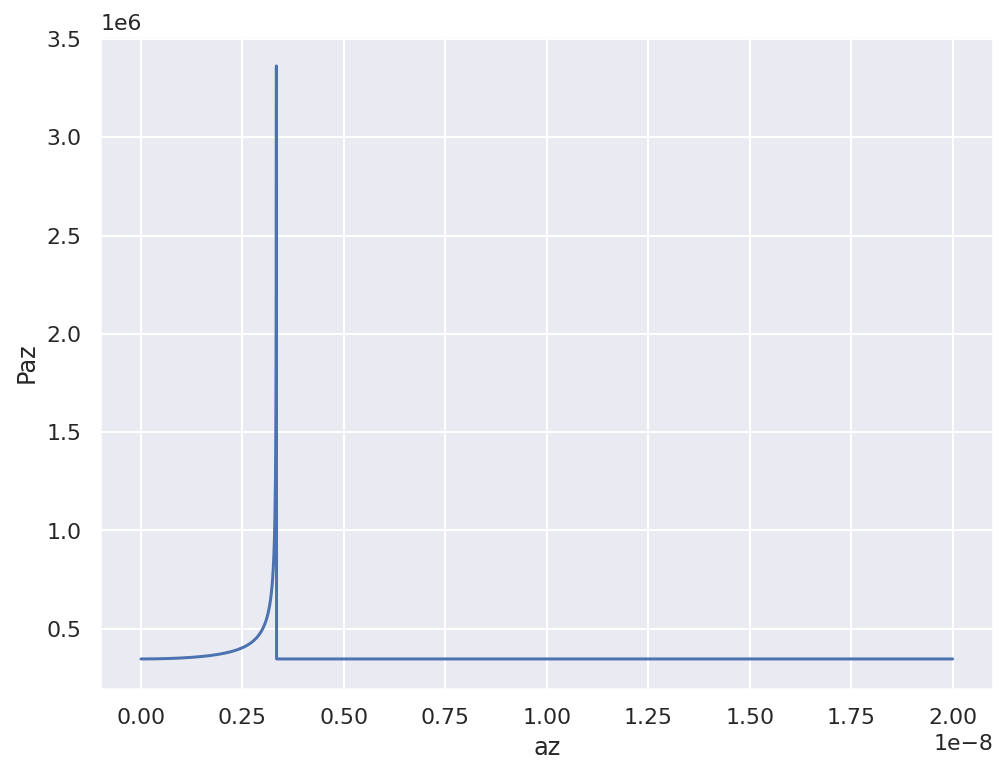

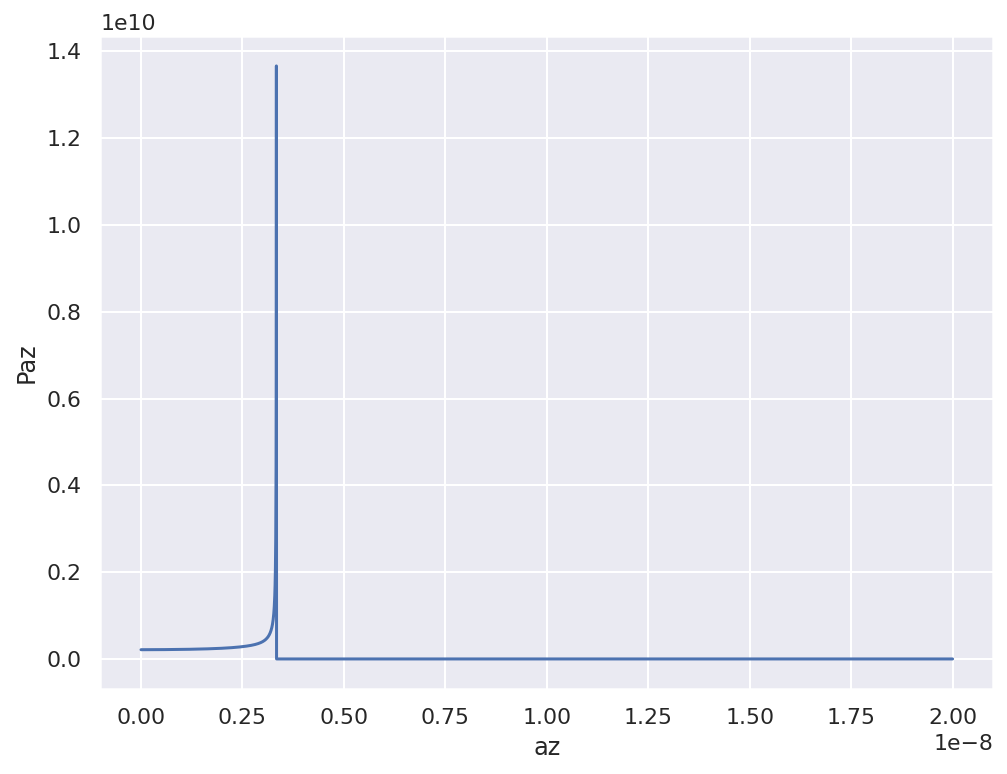

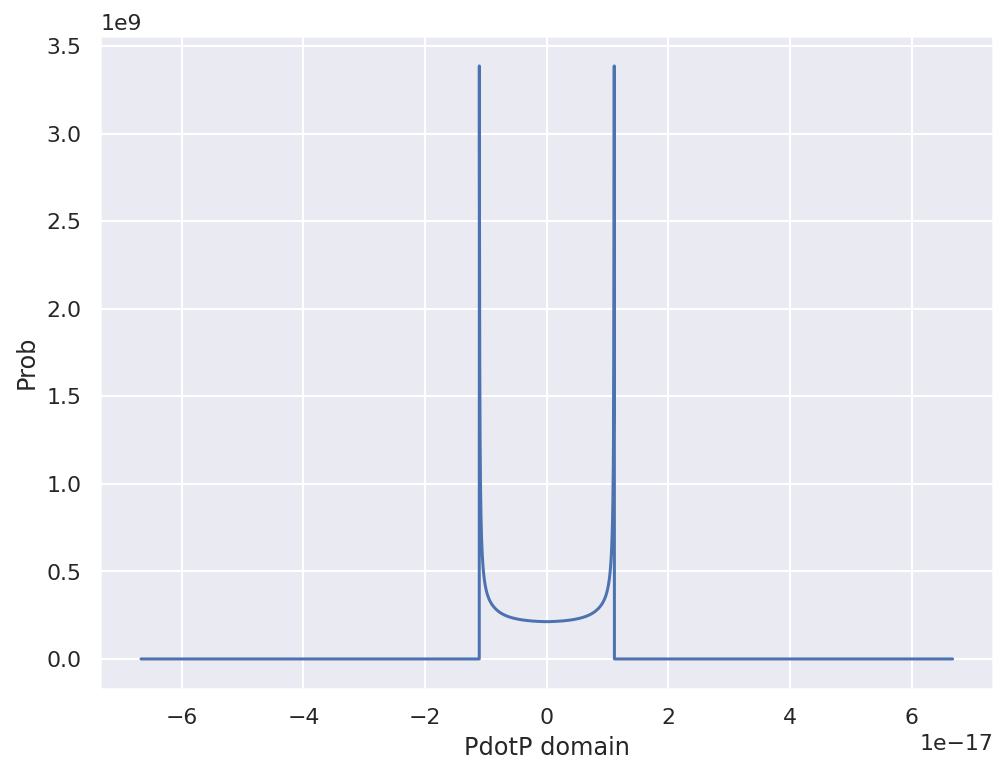

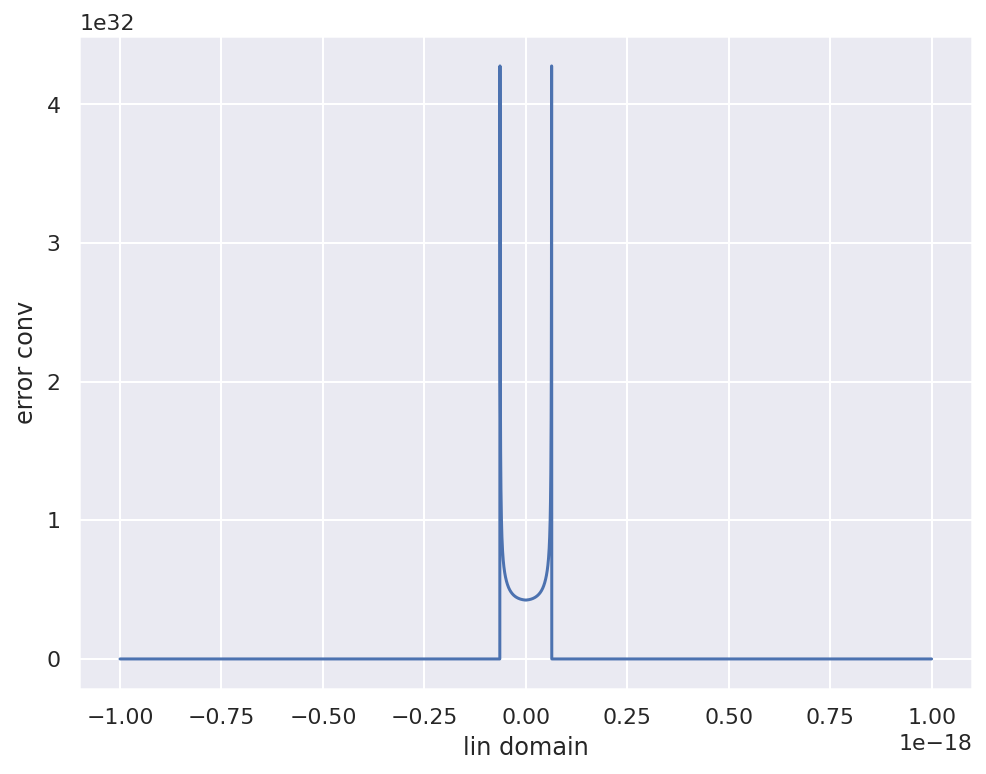

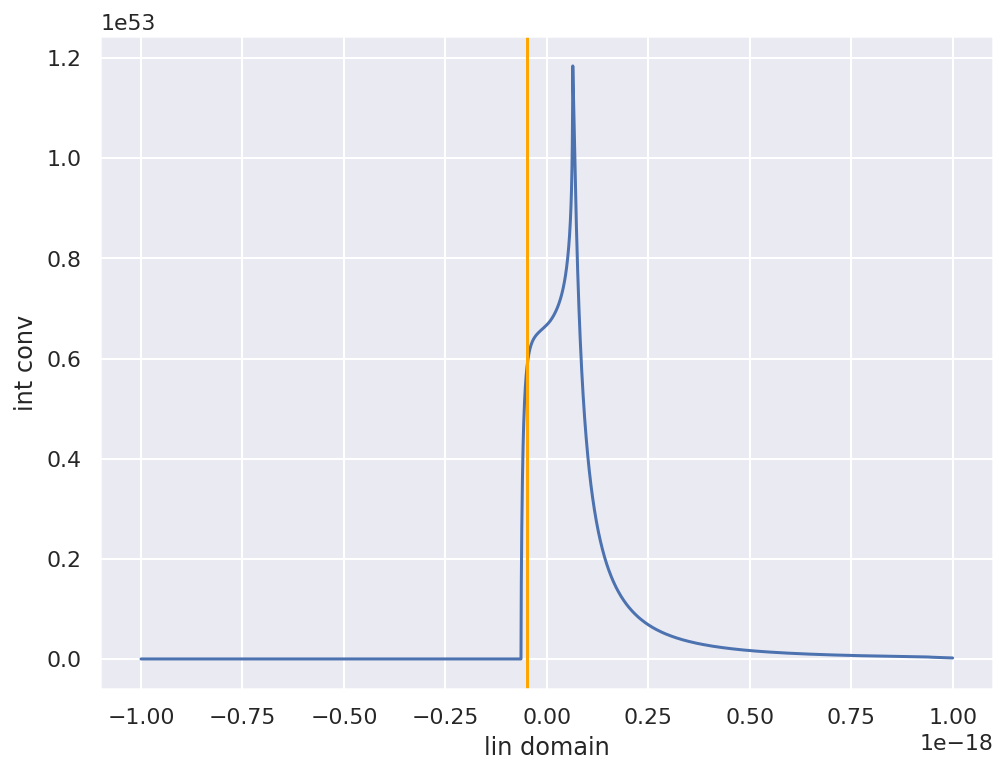

prob dist: <scipy.interpolate.interpolate.interp1d object at 0x7f398c4fc360>


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


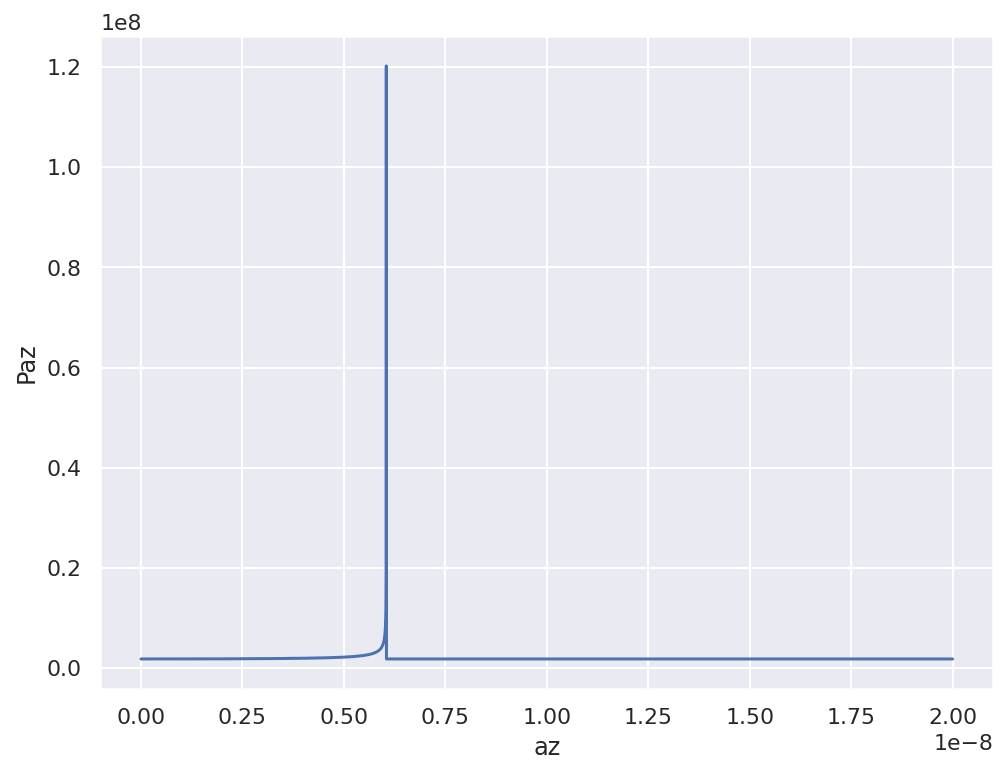

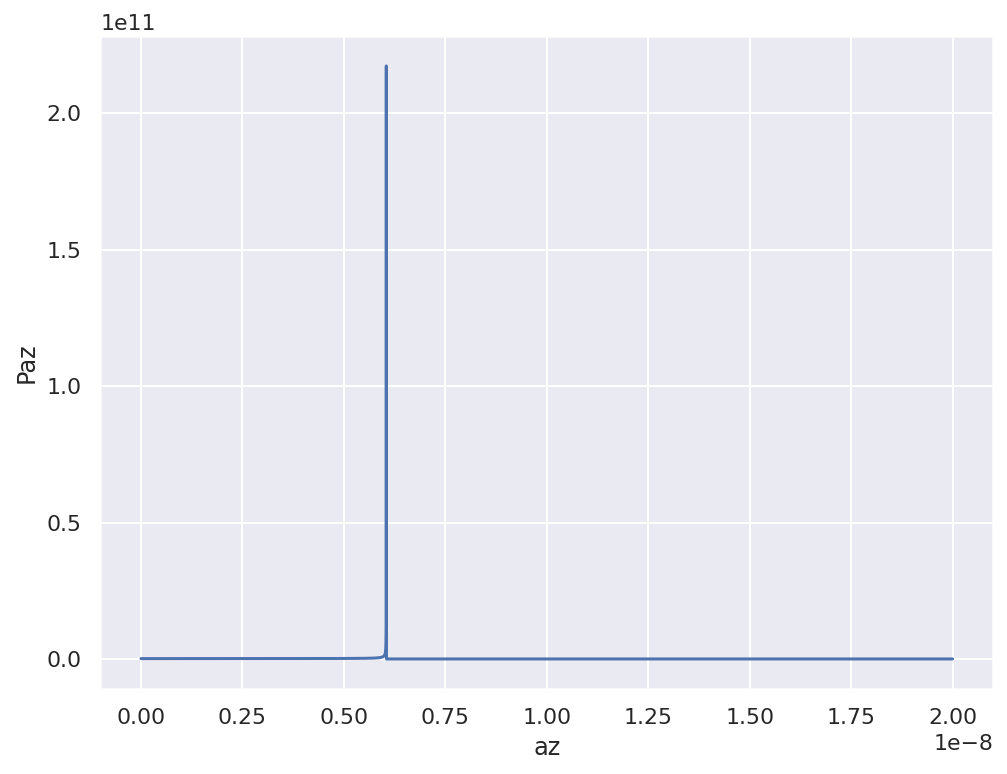

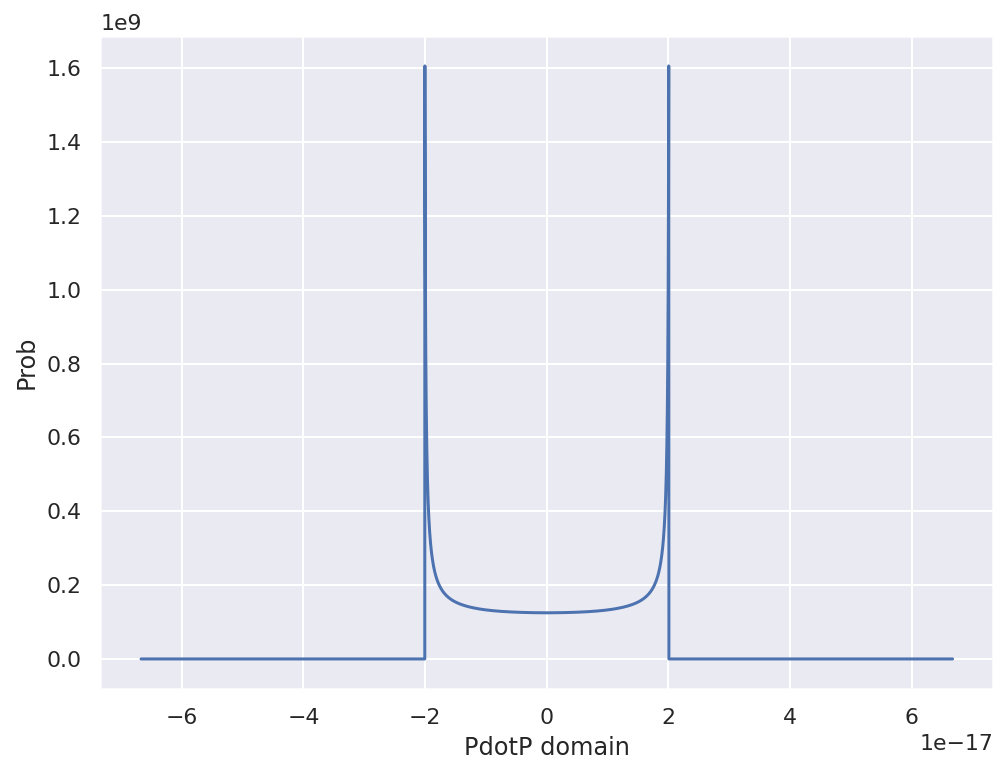

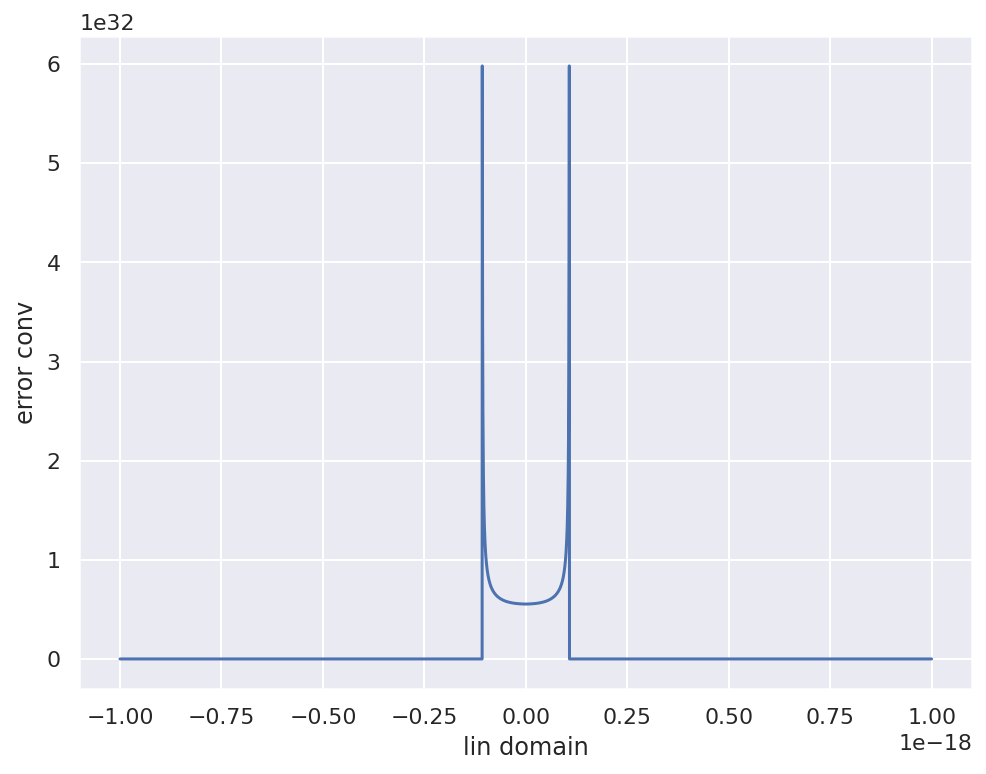

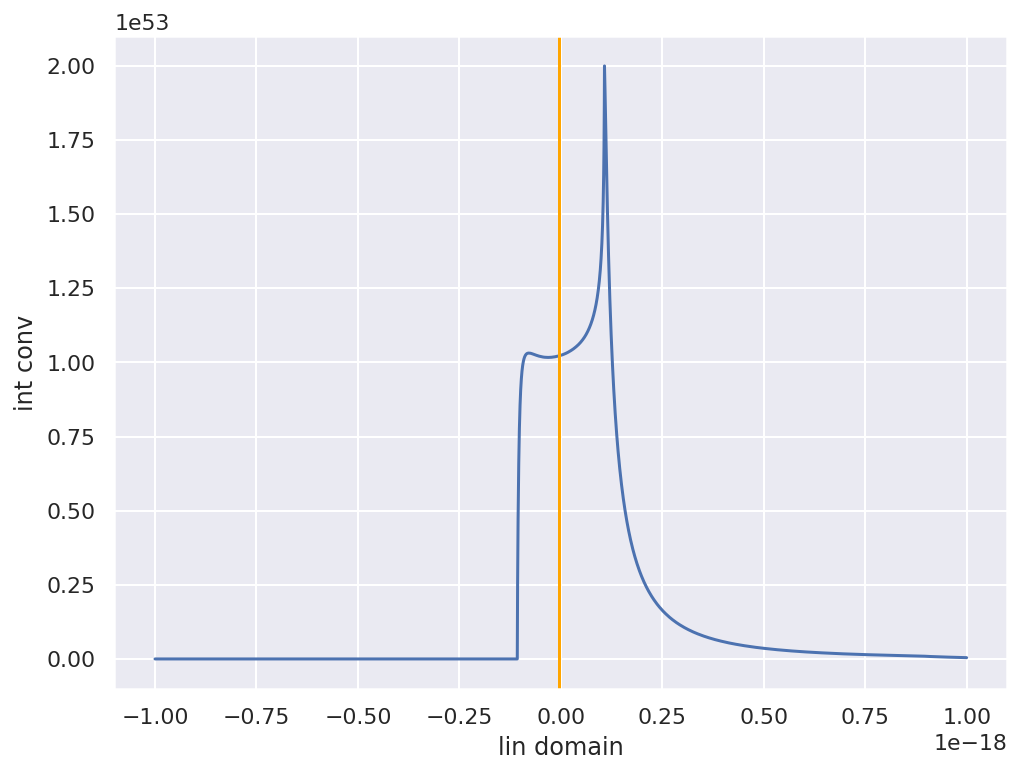

prob dist: <scipy.interpolate.interpolate.interp1d object at 0x7f3982a979f0>


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


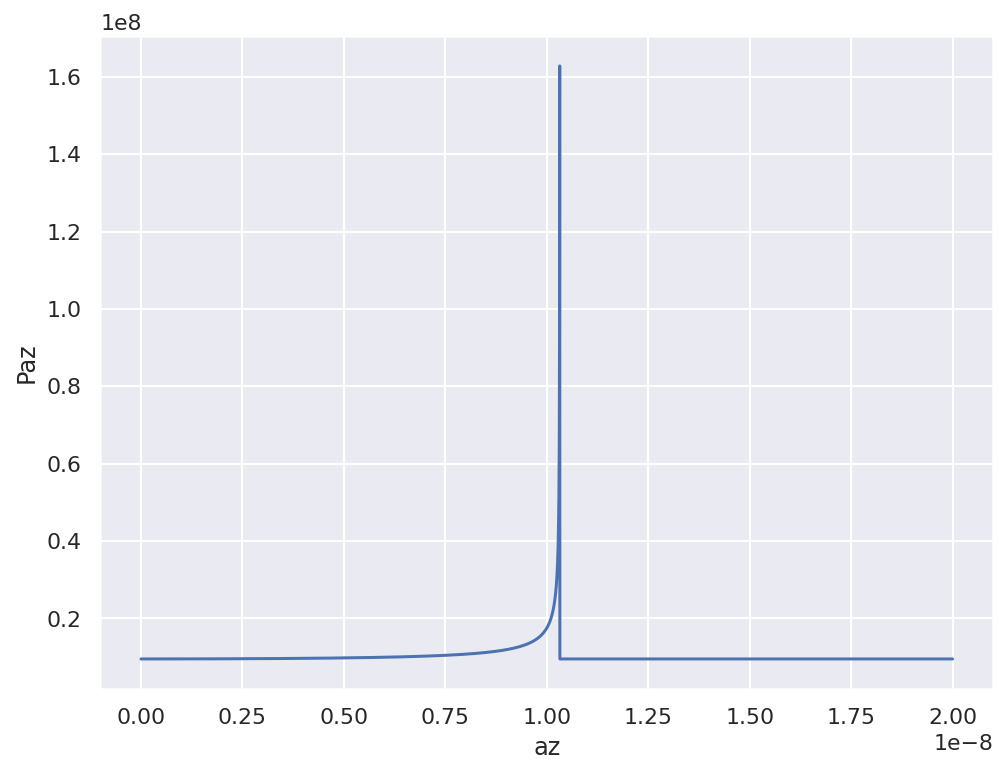

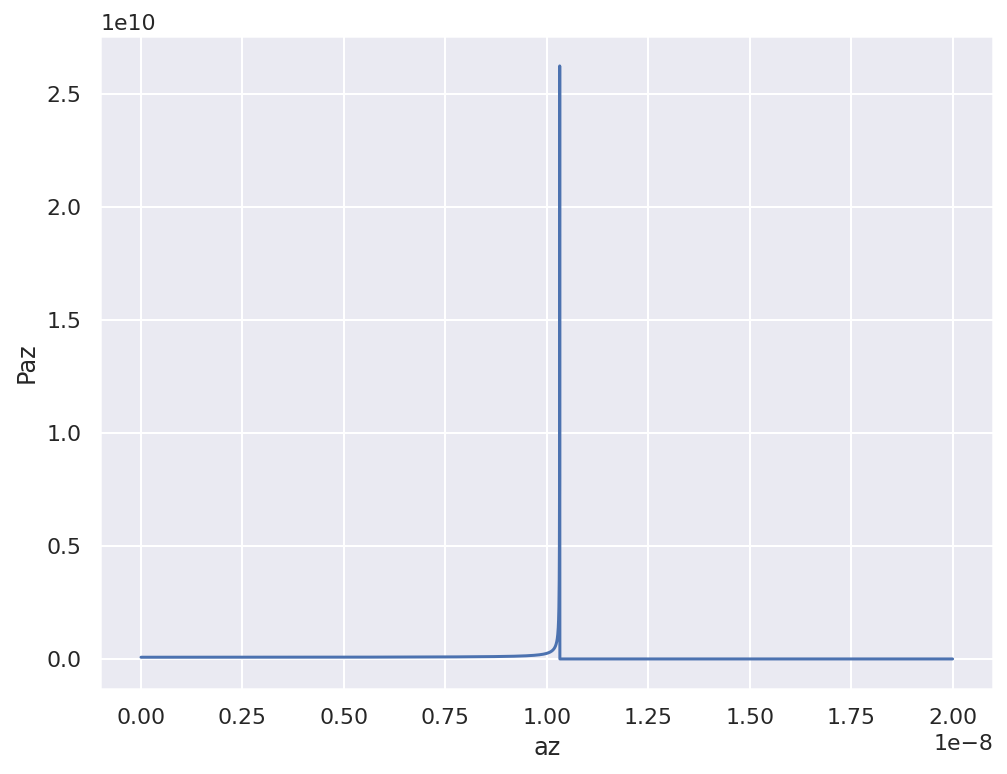

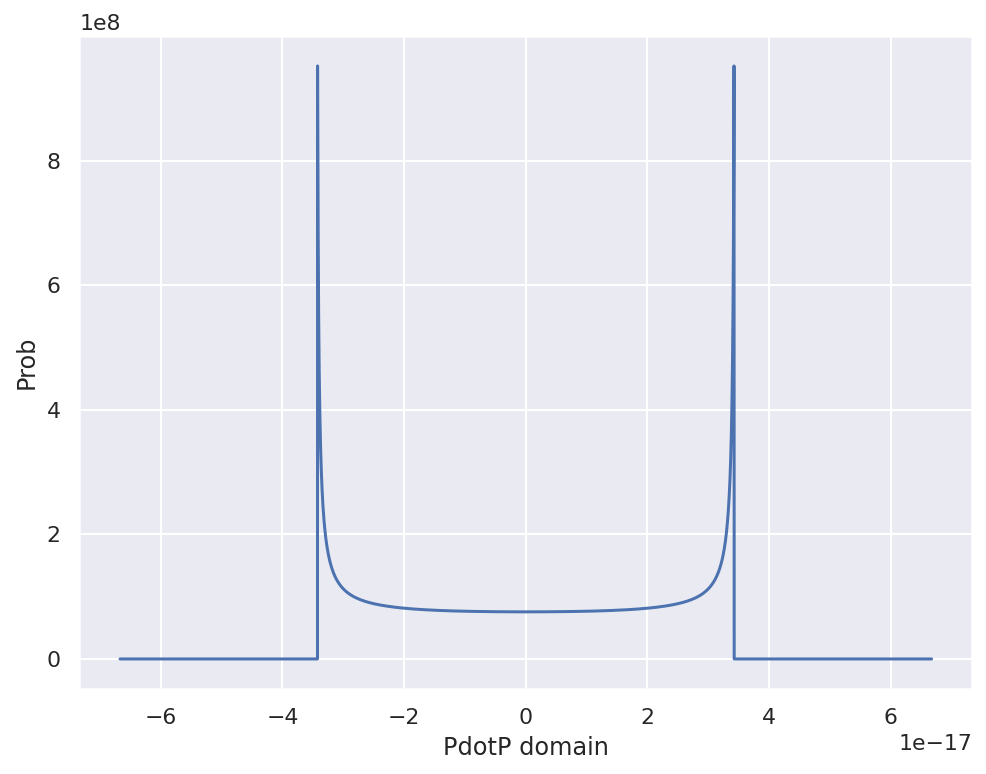

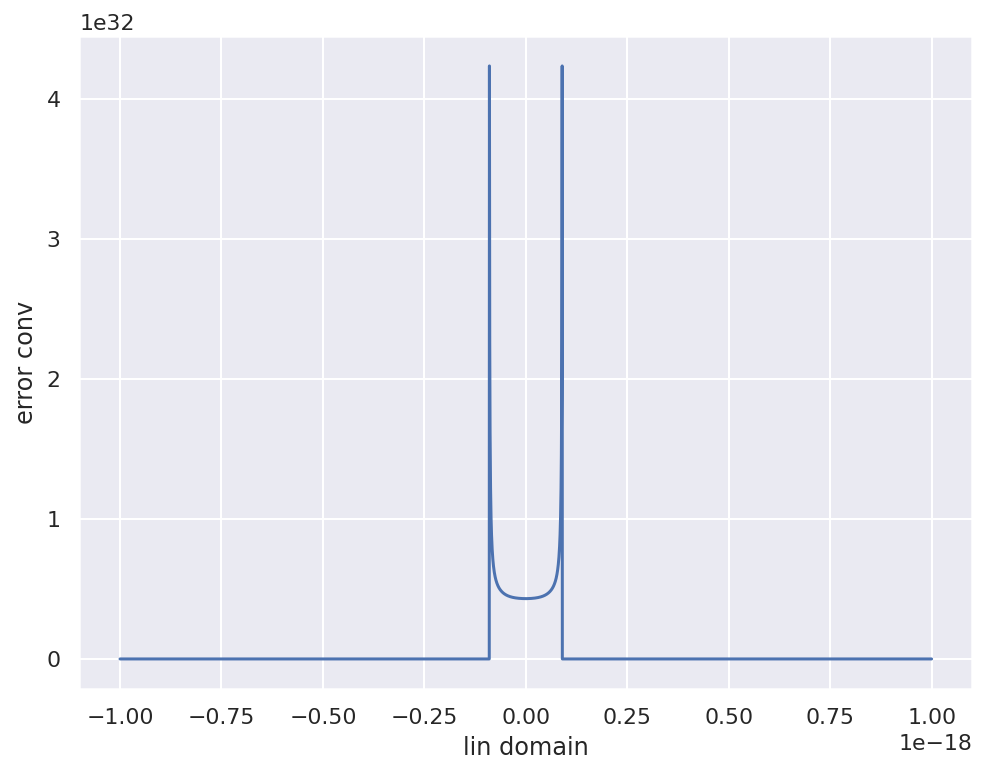

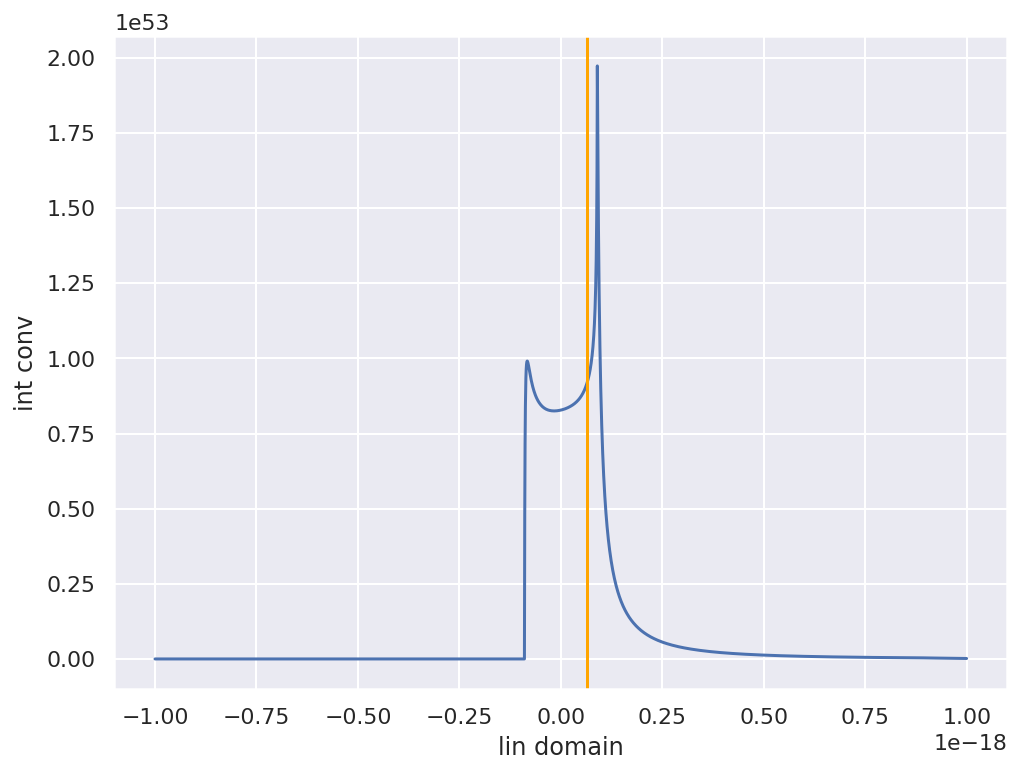

prob dist: <scipy.interpolate.interpolate.interp1d object at 0x7f3982a82d60>


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


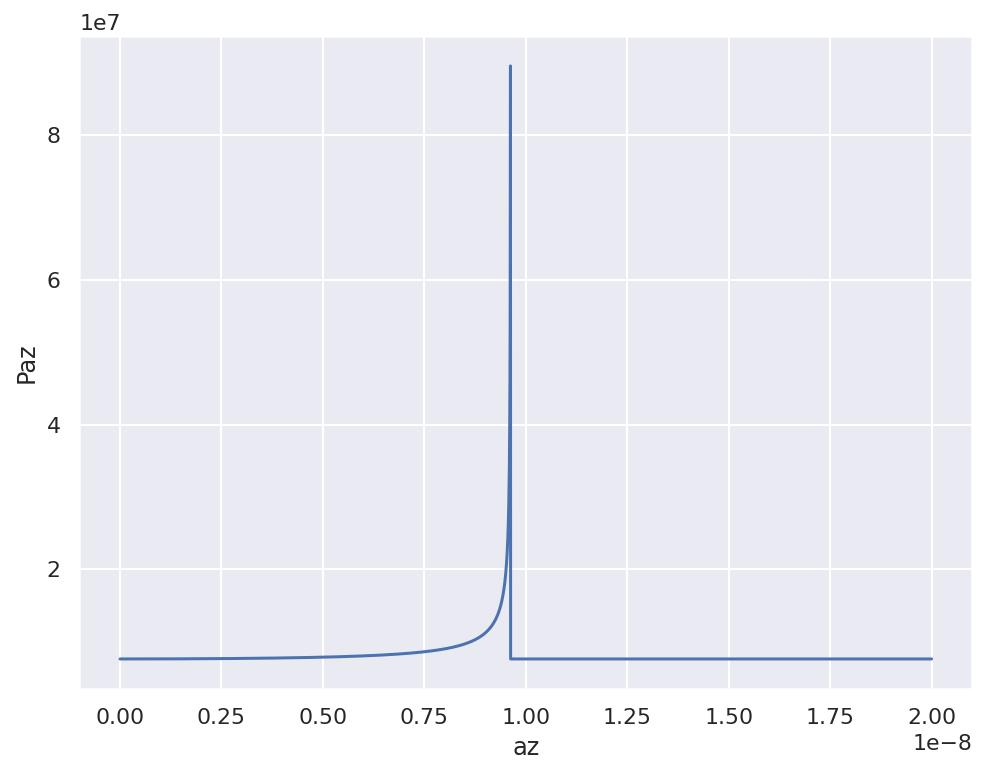

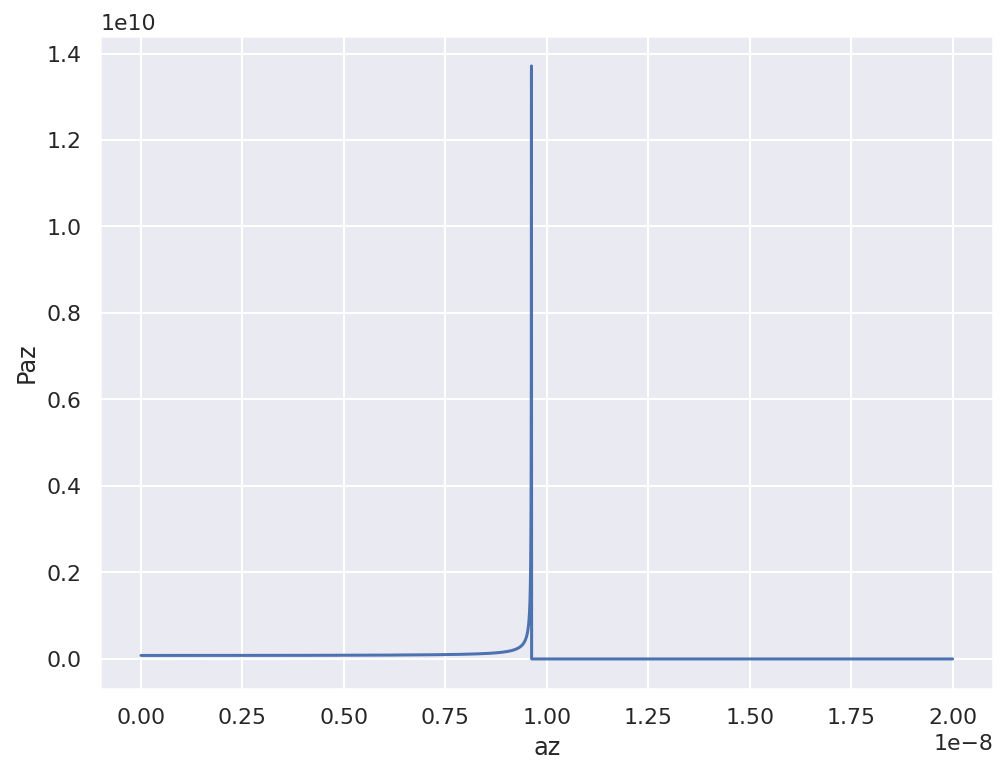

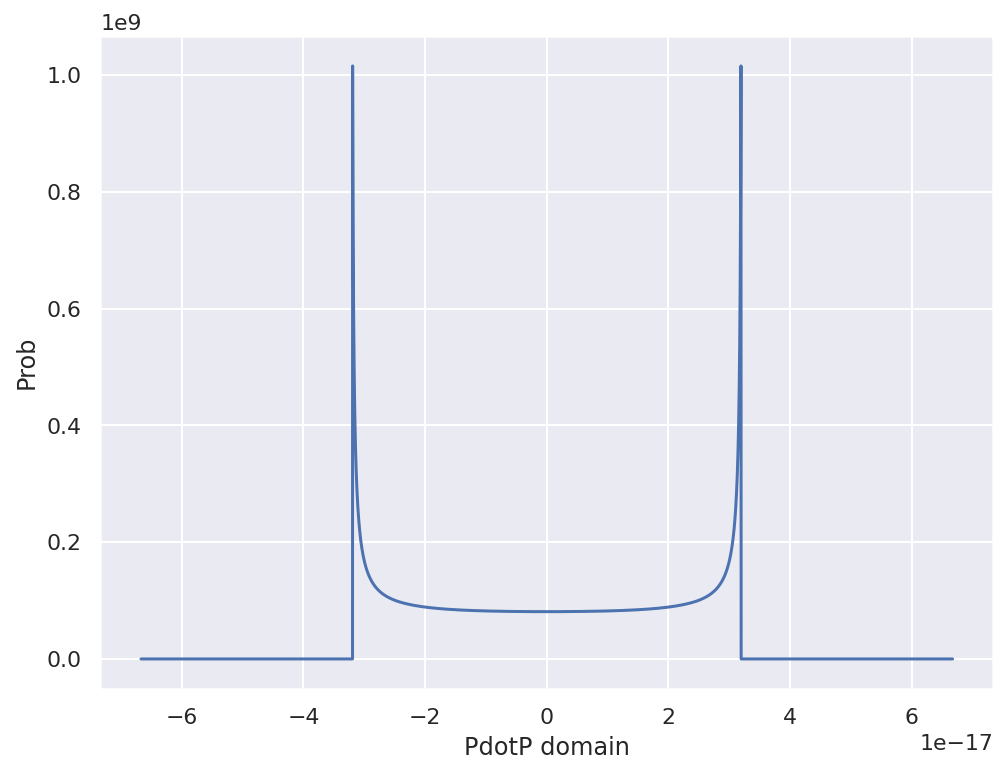

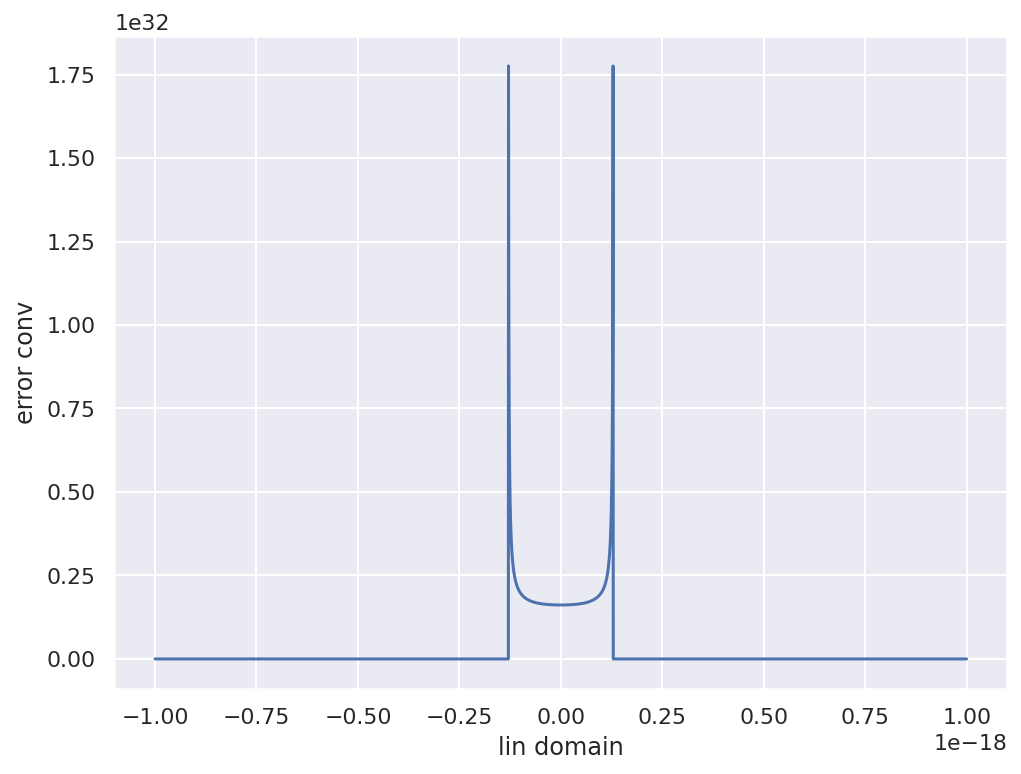

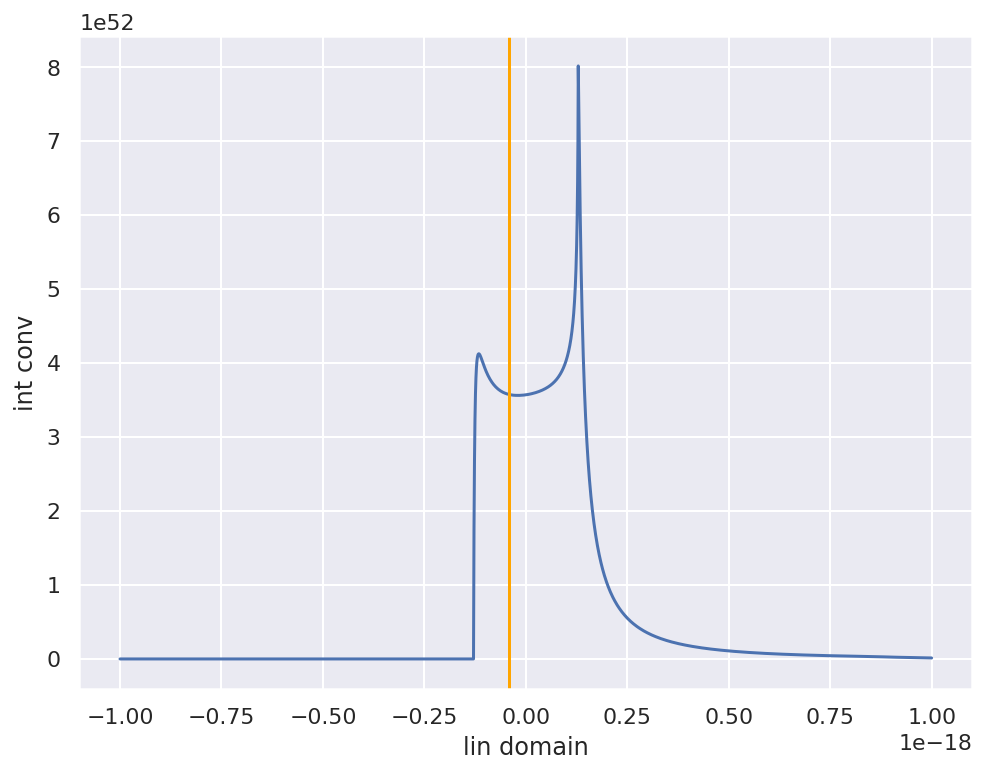

prob dist: <scipy.interpolate.interpolate.interp1d object at 0x7f398c44b040>


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


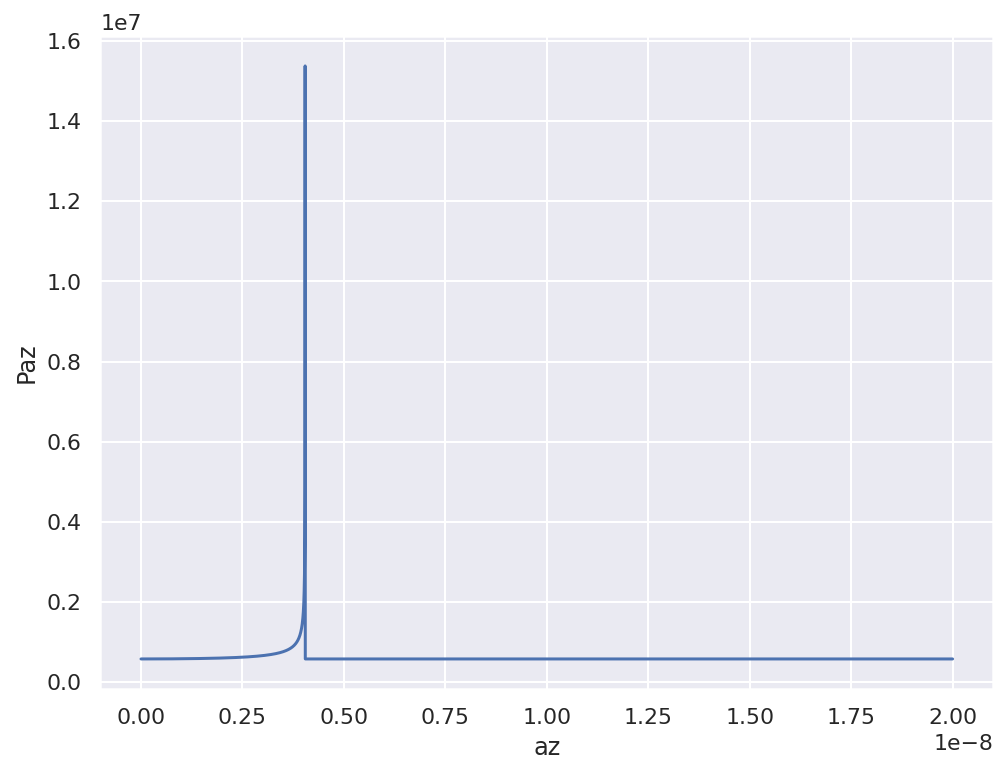

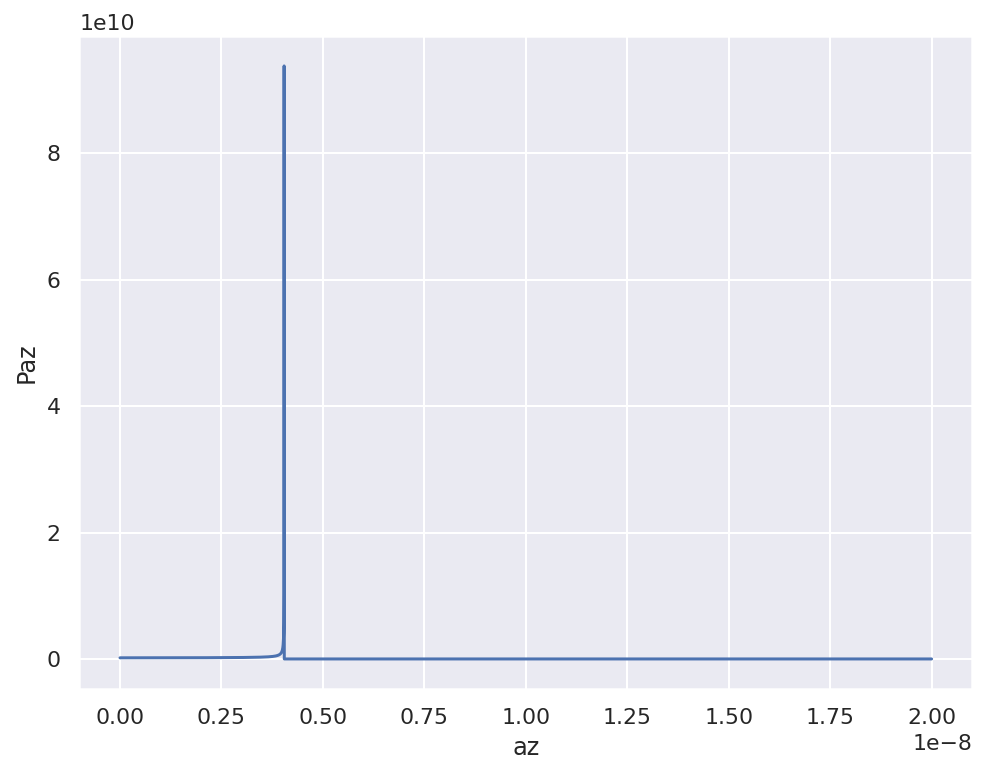

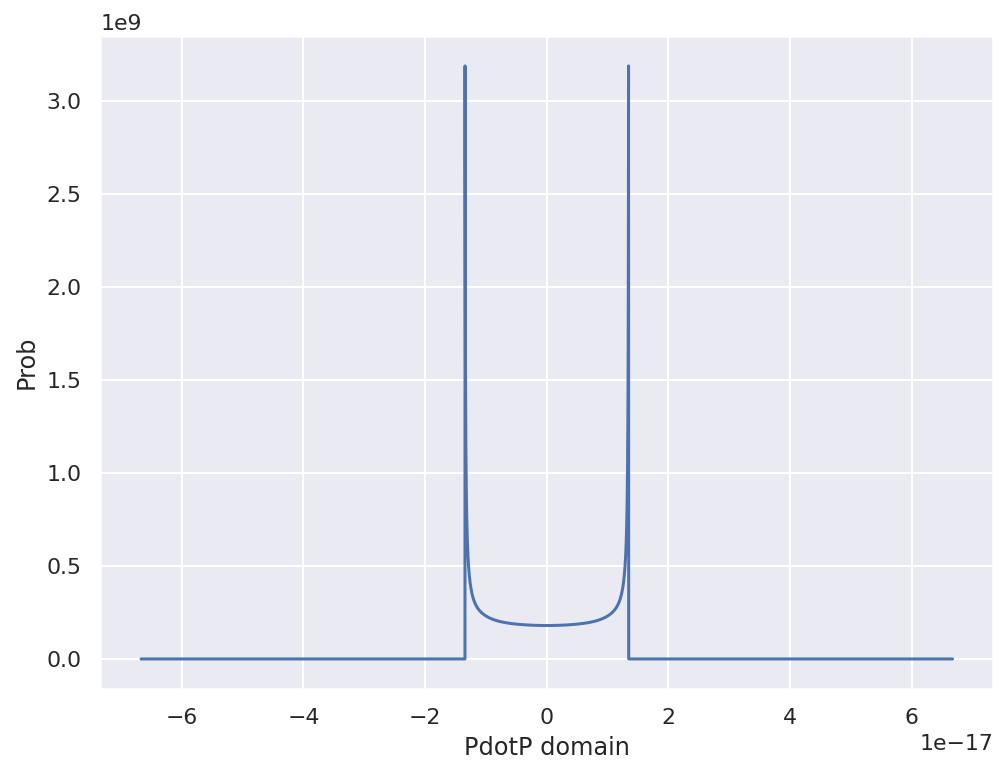

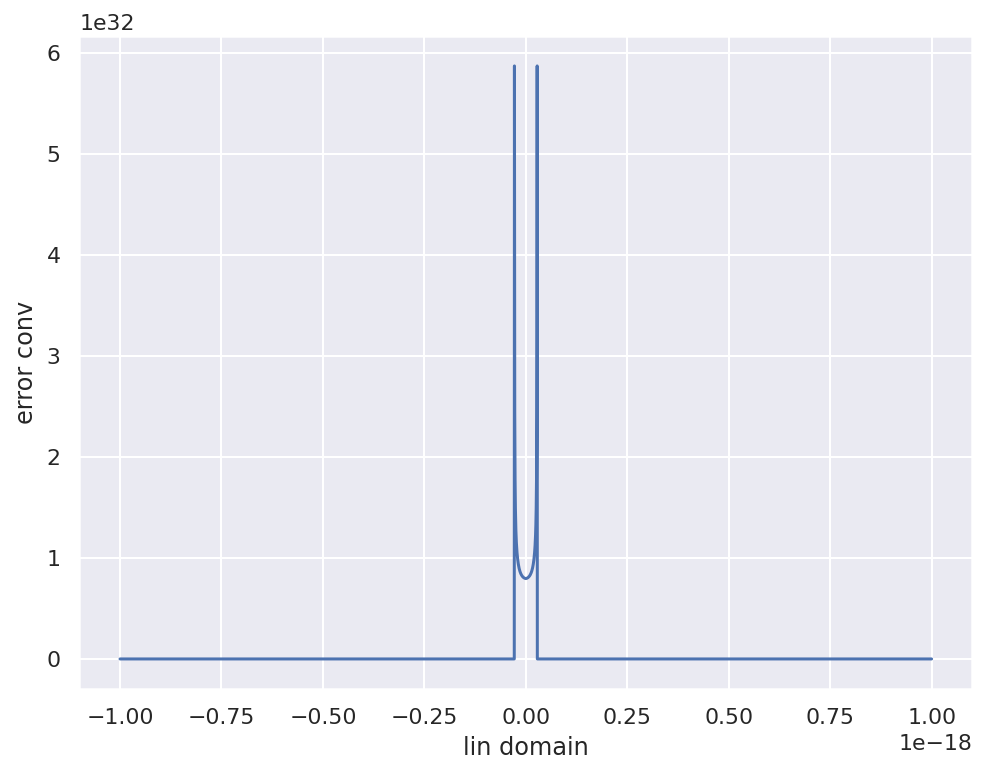

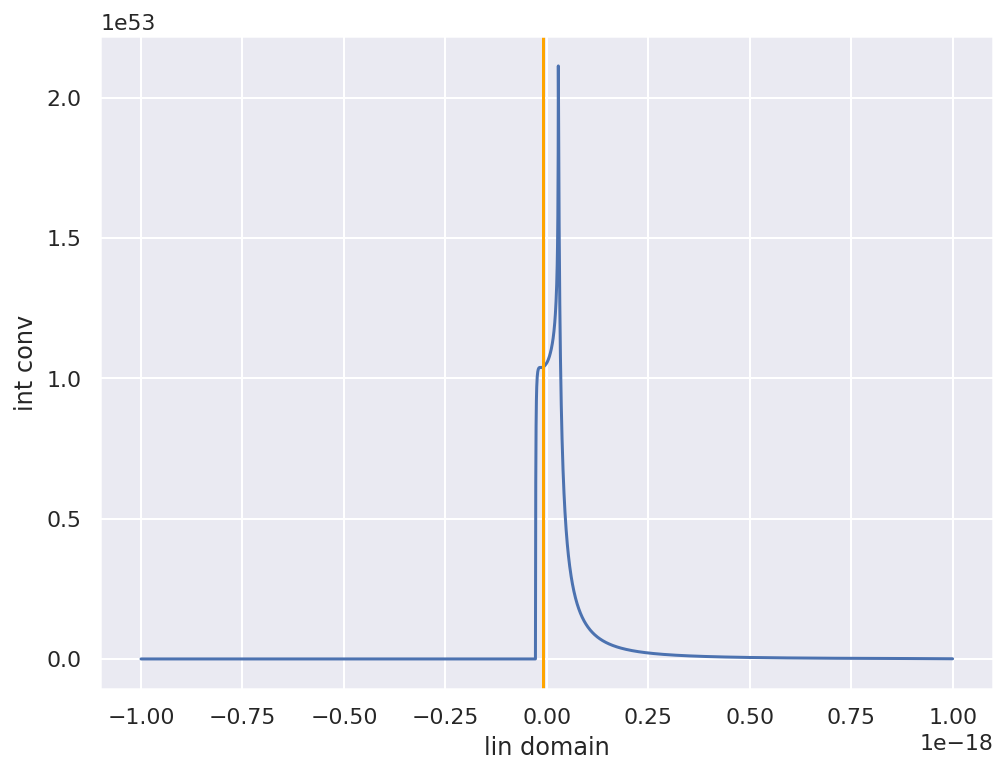

prob dist: <scipy.interpolate.interpolate.interp1d object at 0x7f3982a1dd60>


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


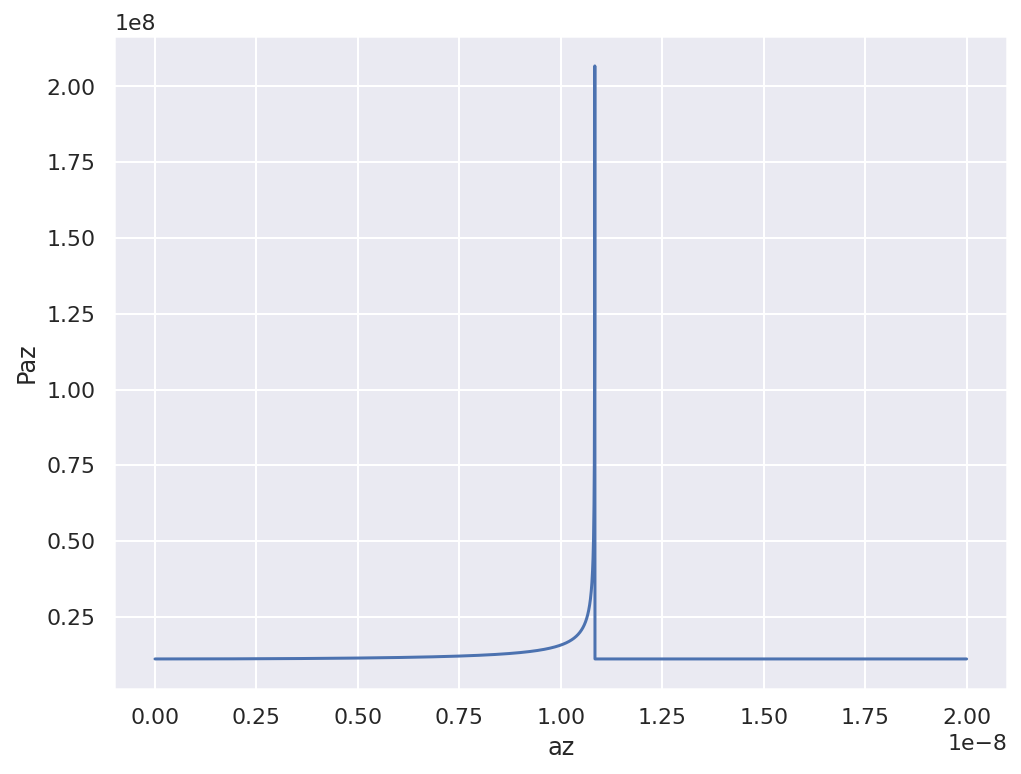

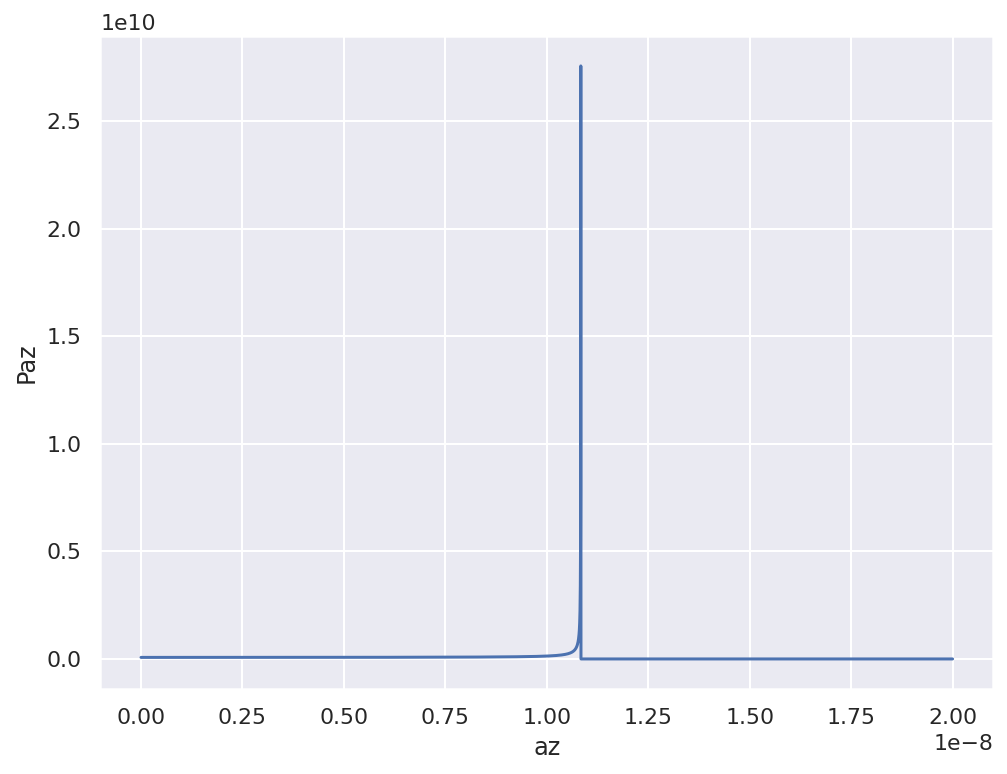

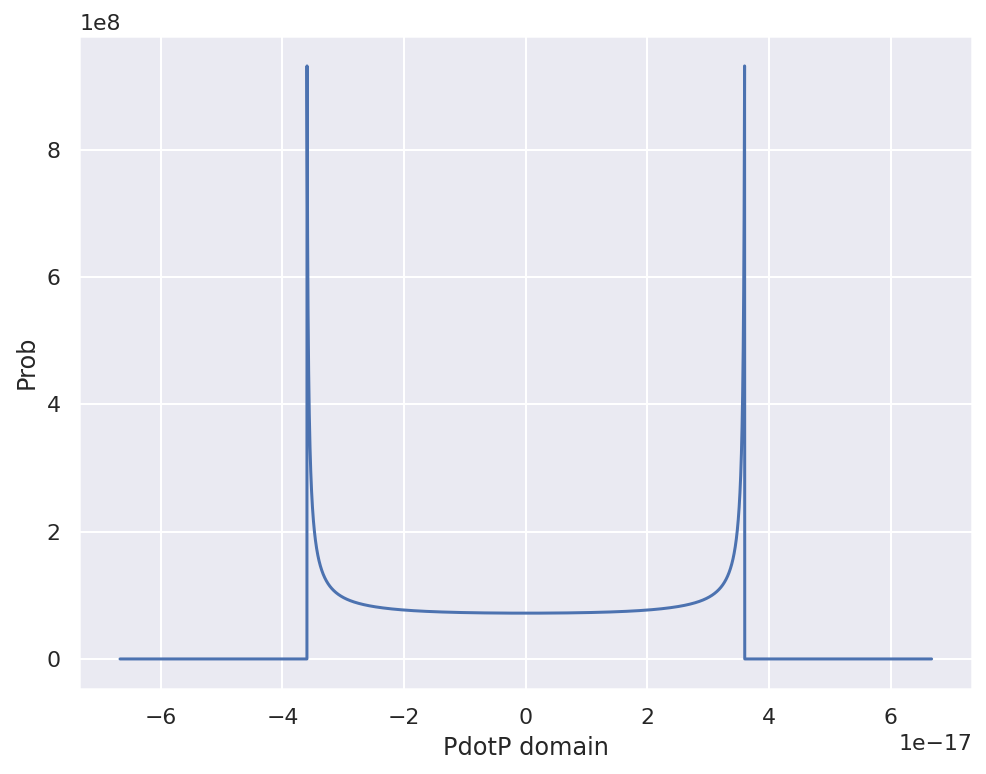

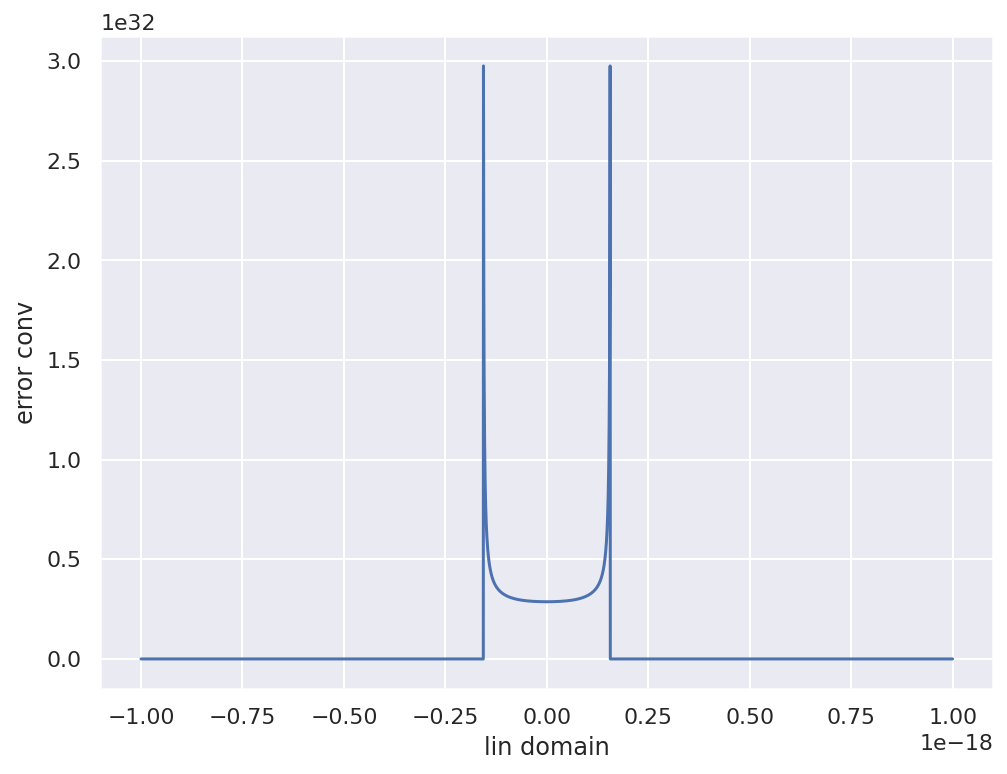

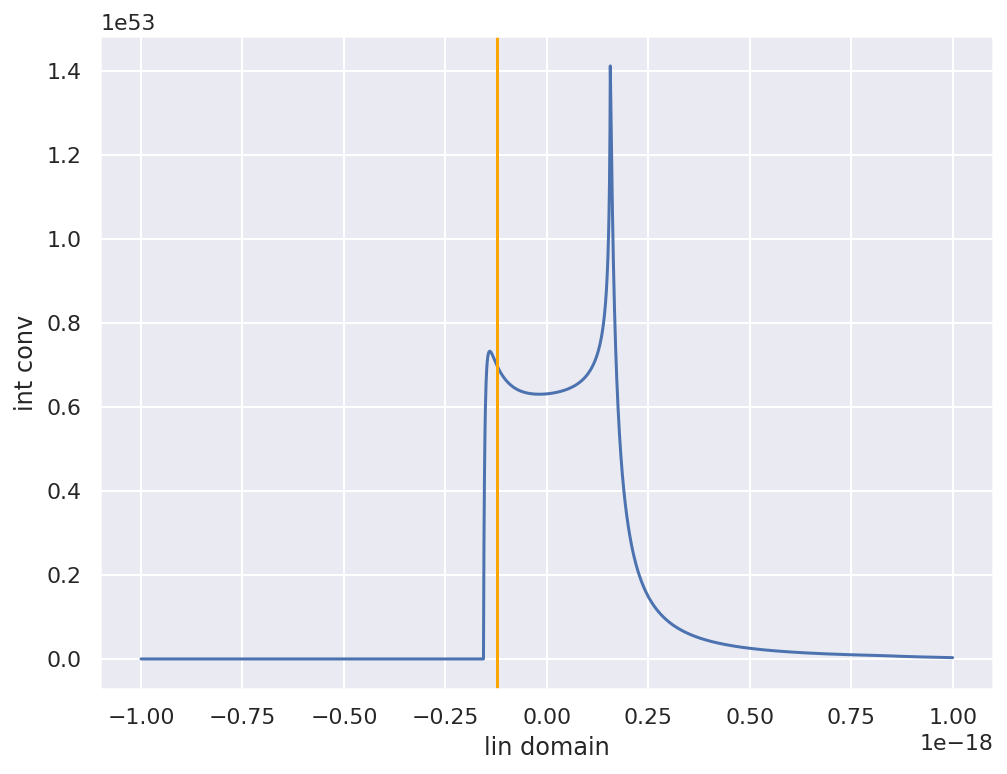

prob dist: <scipy.interpolate.interpolate.interp1d object at 0x7f39d34a4e00>


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


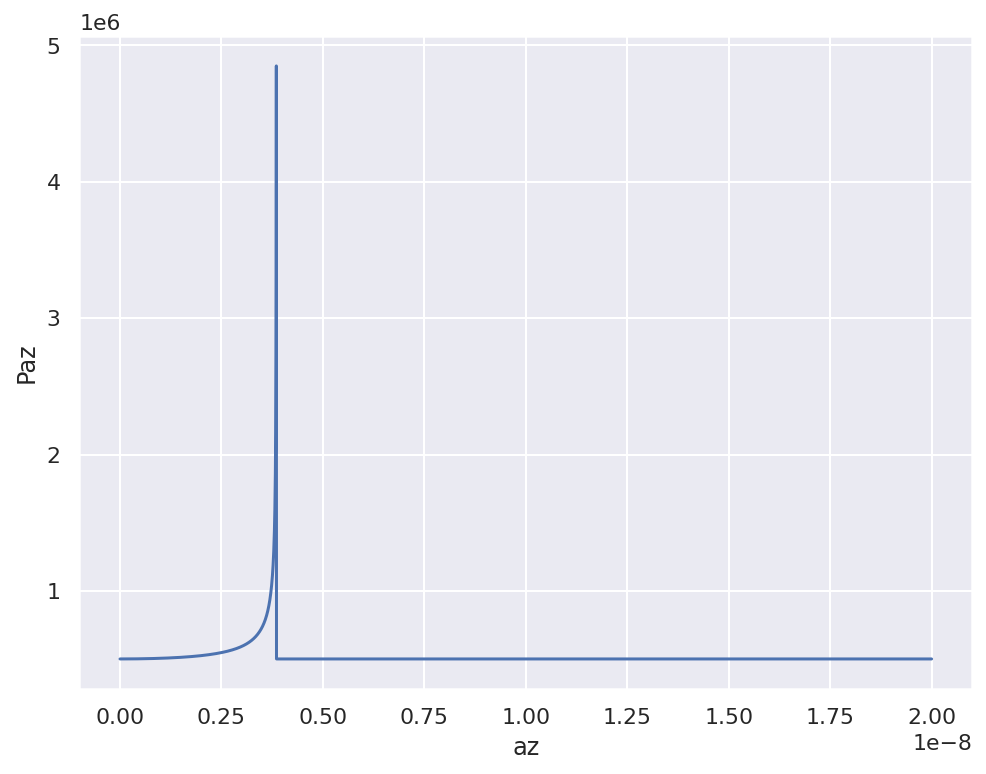

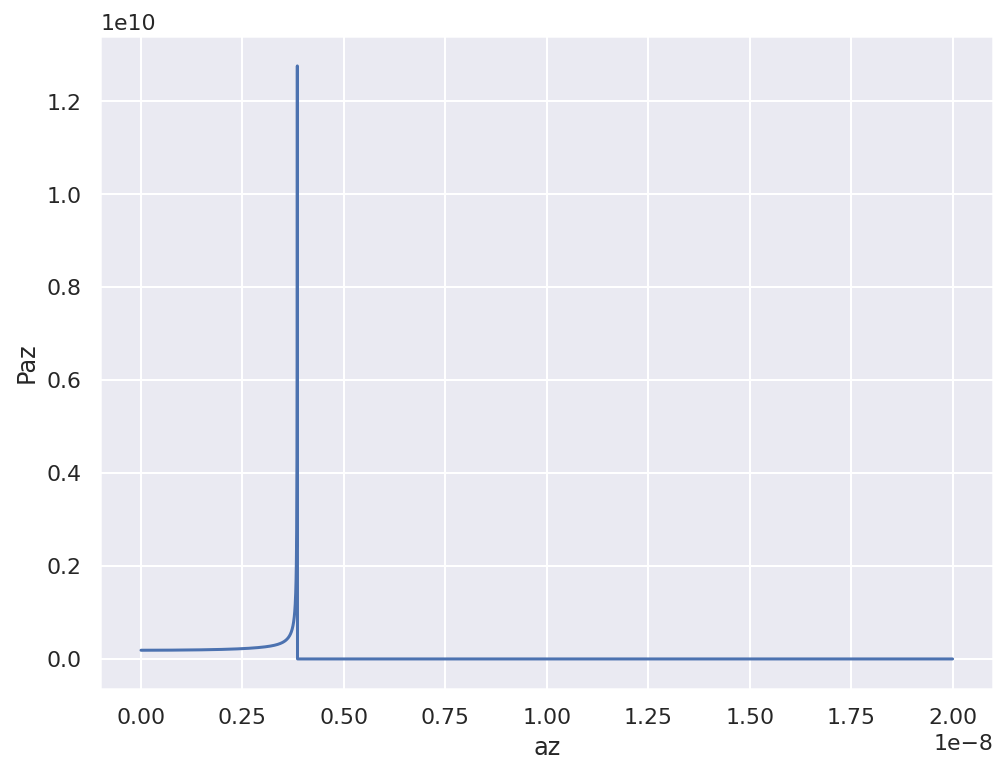

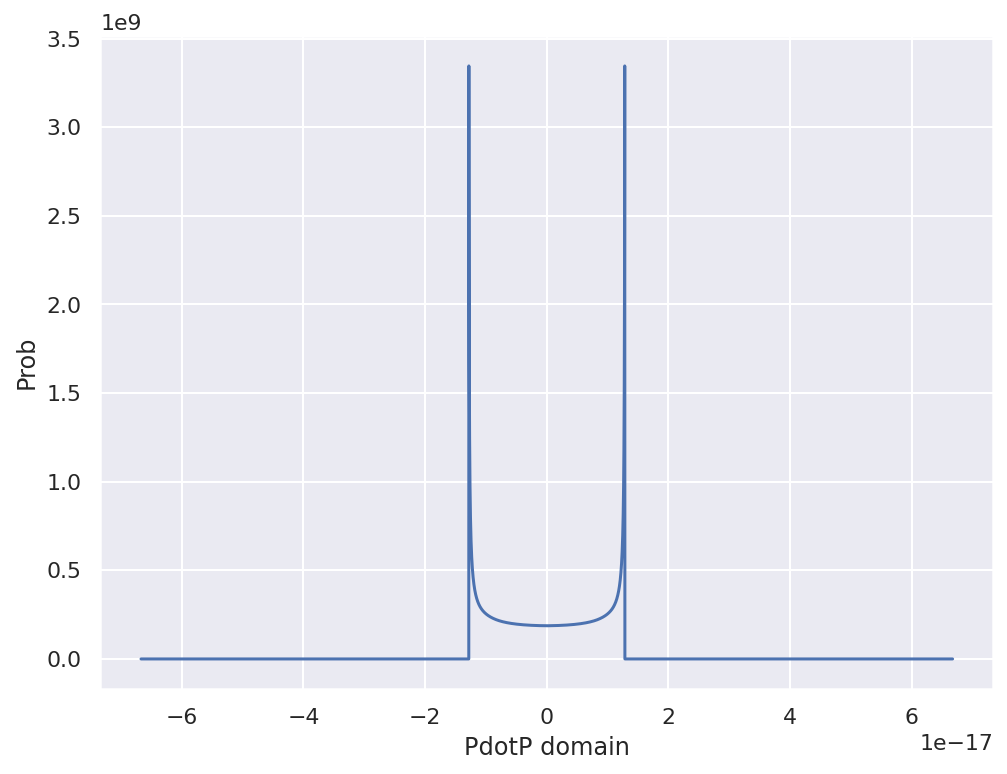

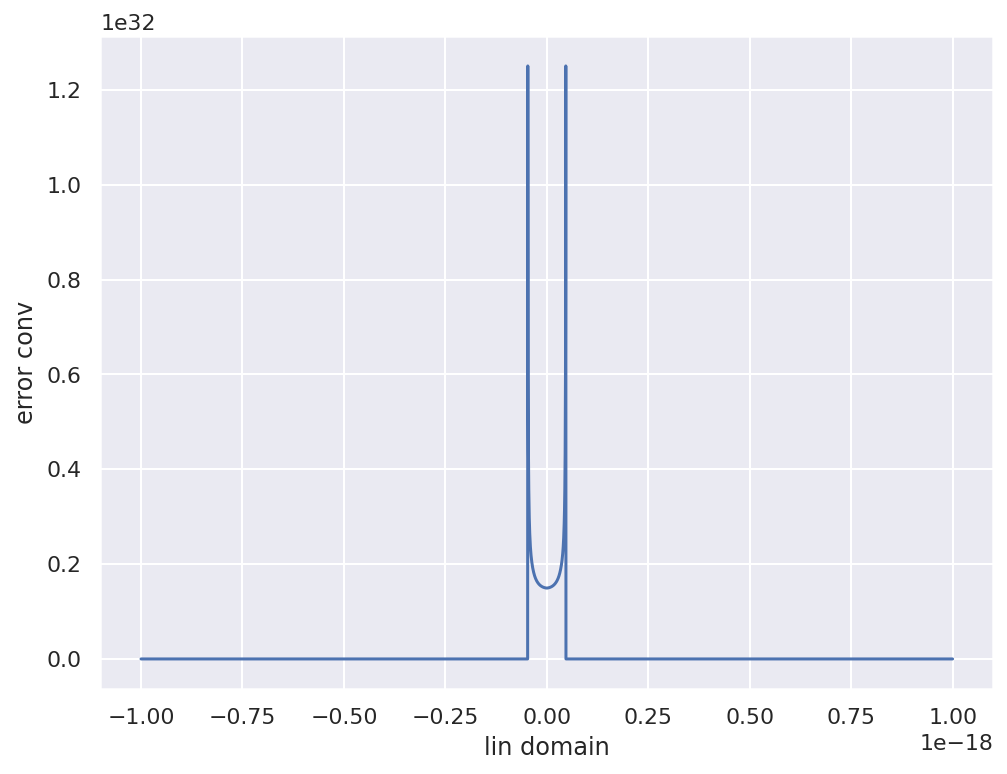

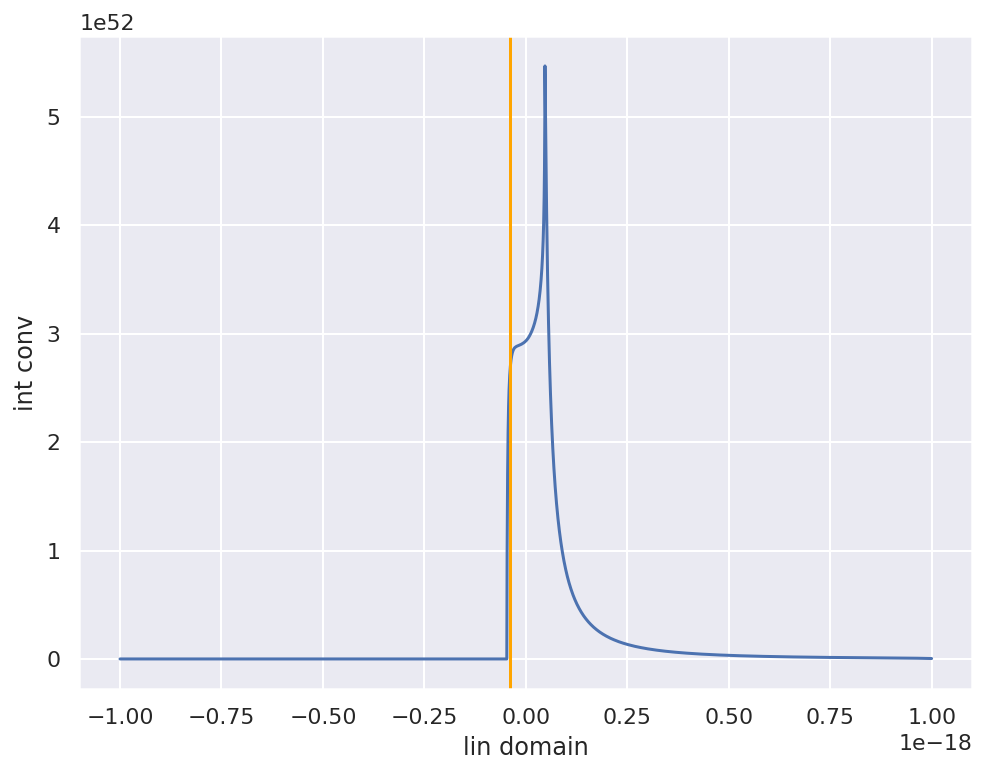

prob dist: <scipy.interpolate.interpolate.interp1d object at 0x7f3982b8e900>


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


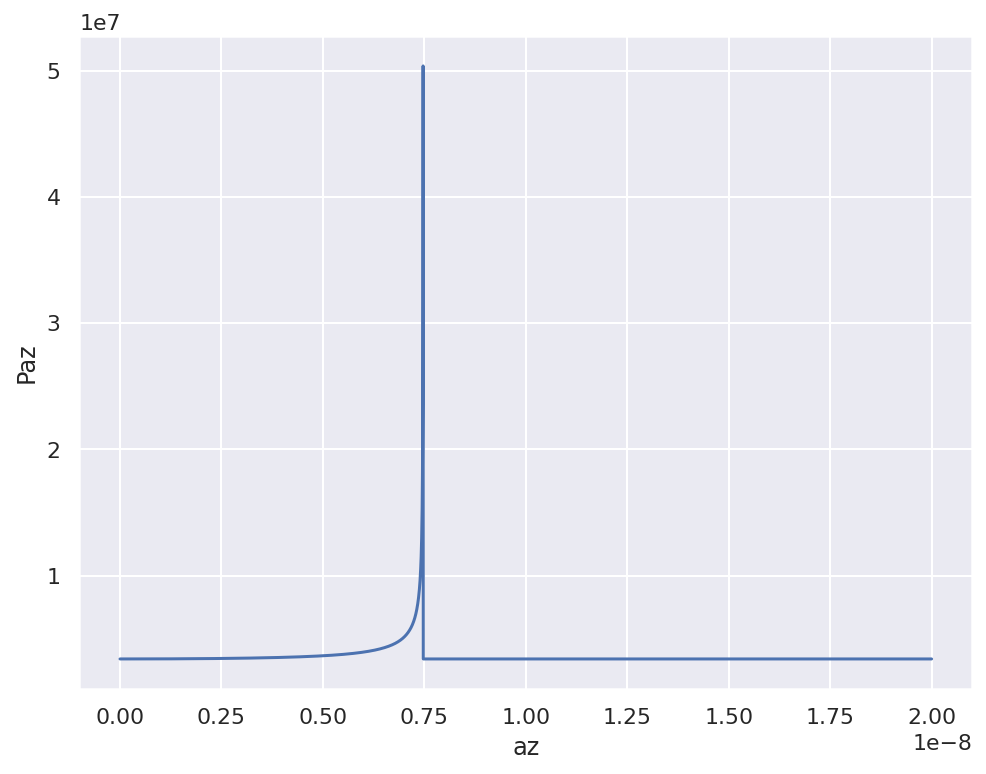

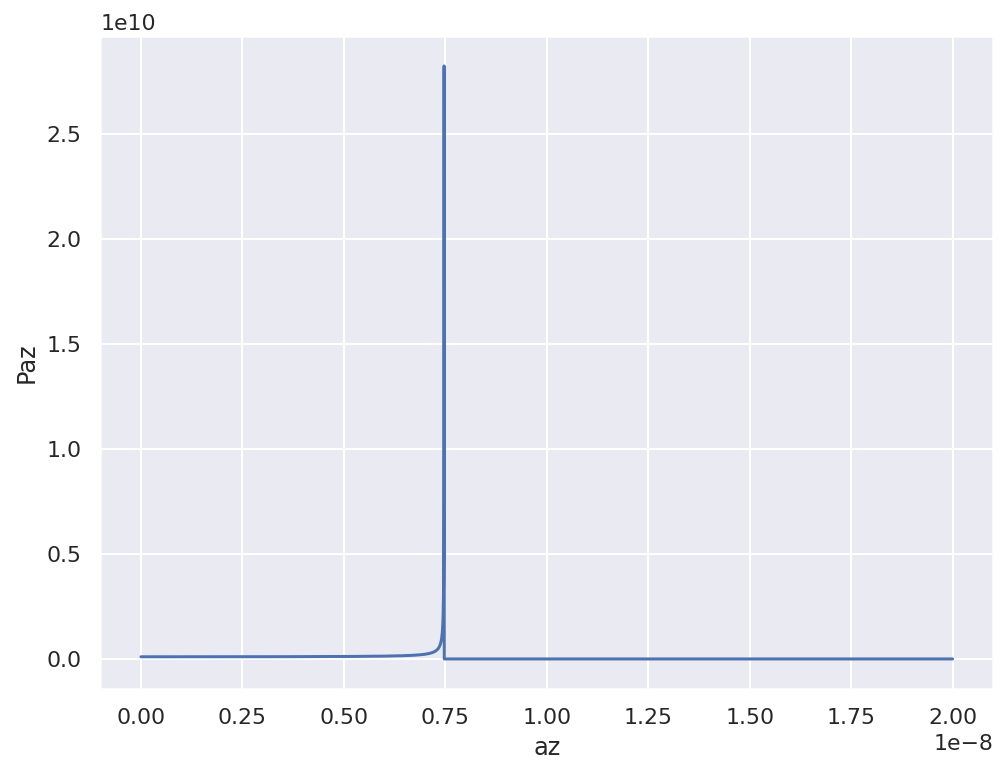

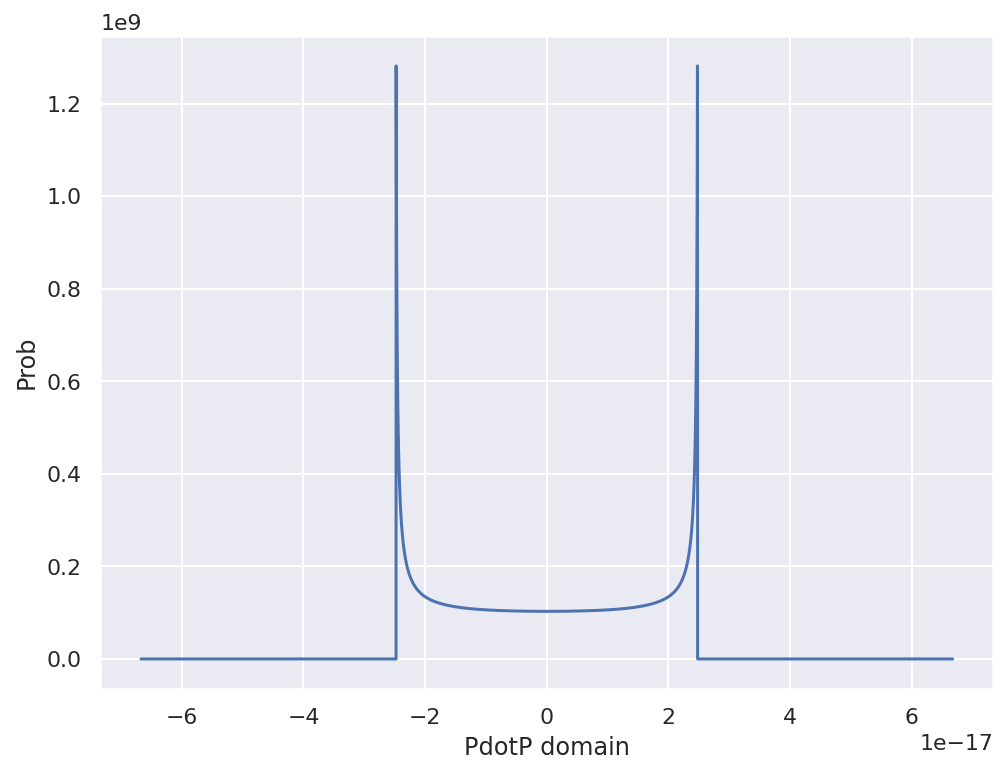

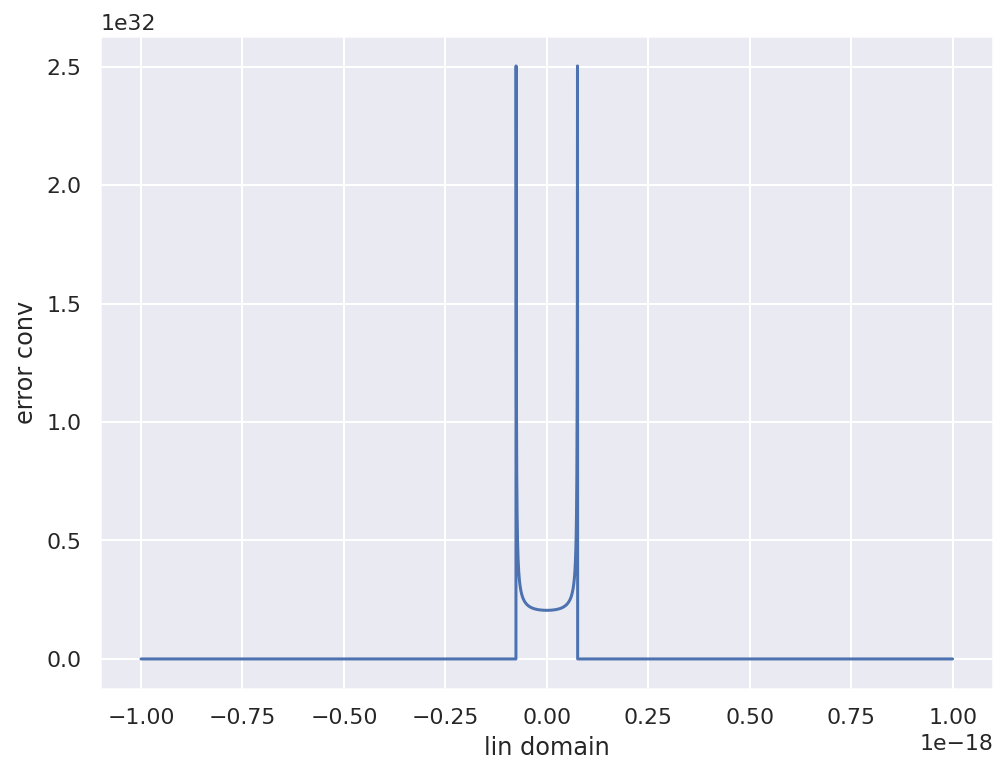

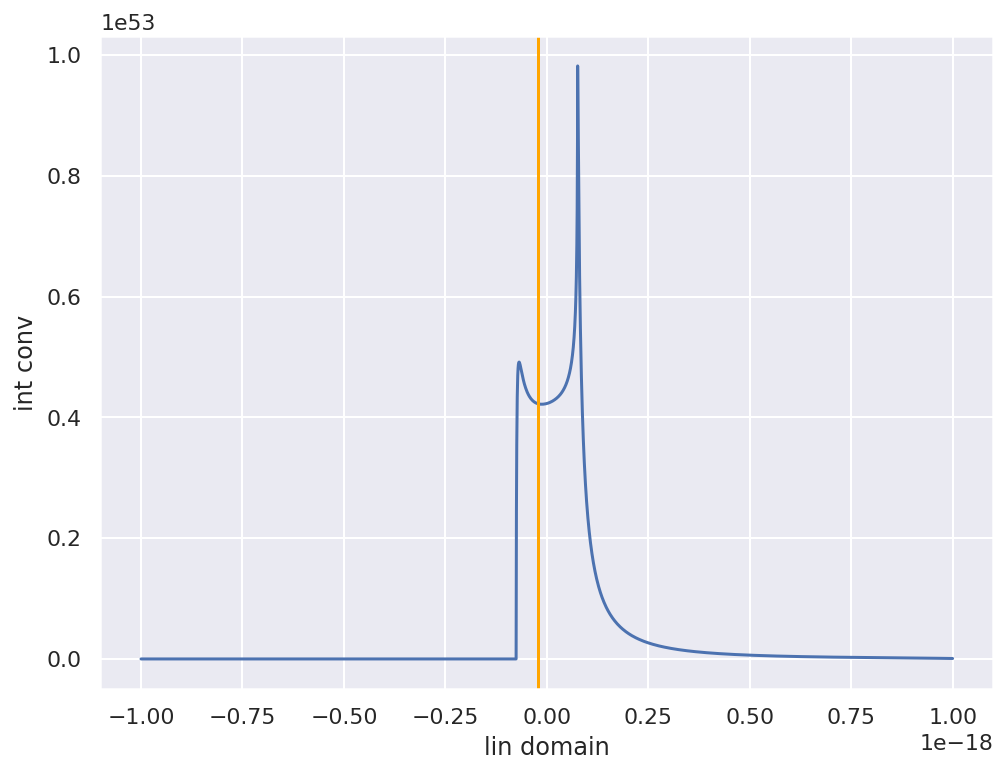

prob dist: <scipy.interpolate.interpolate.interp1d object at 0x7f3982a9f770>


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


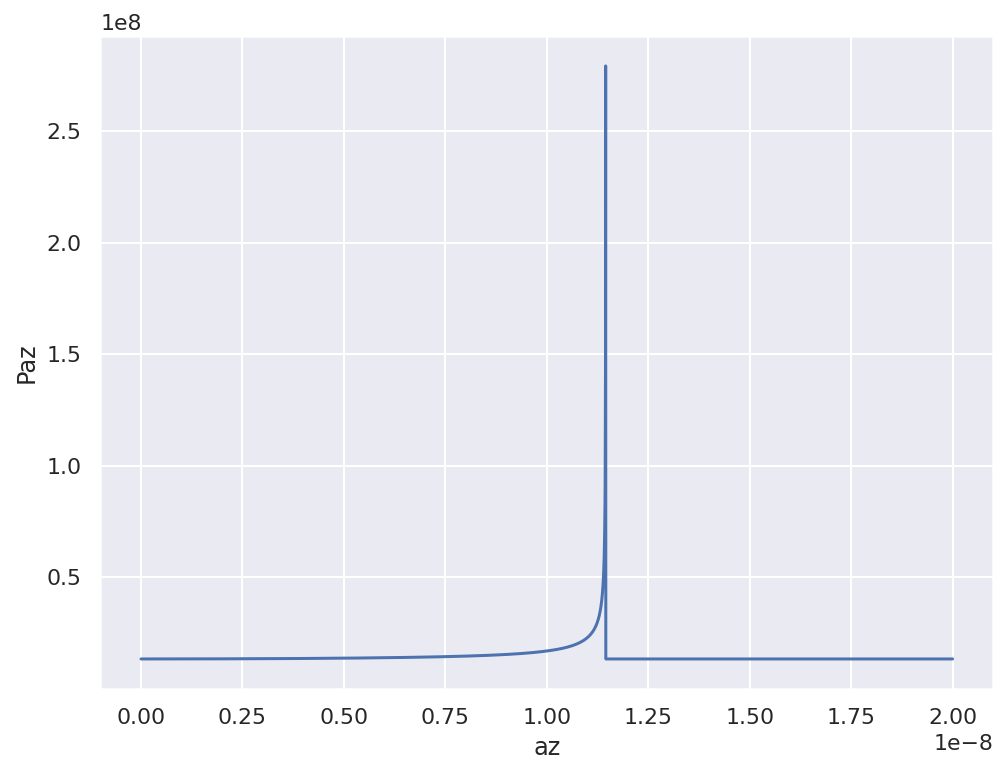

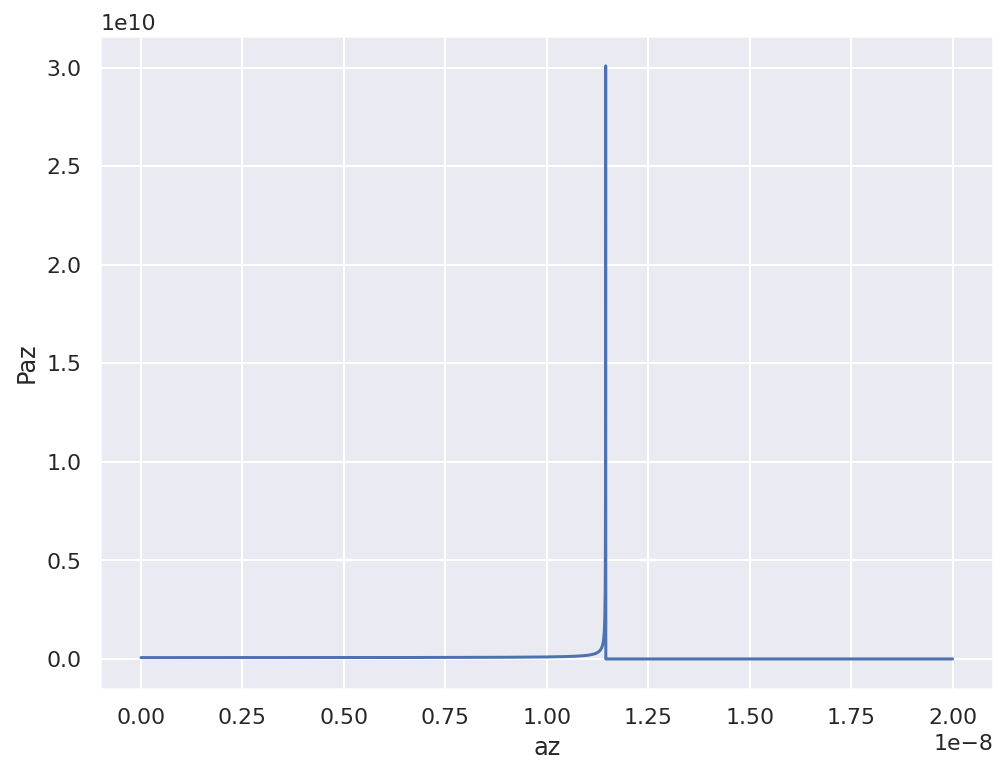

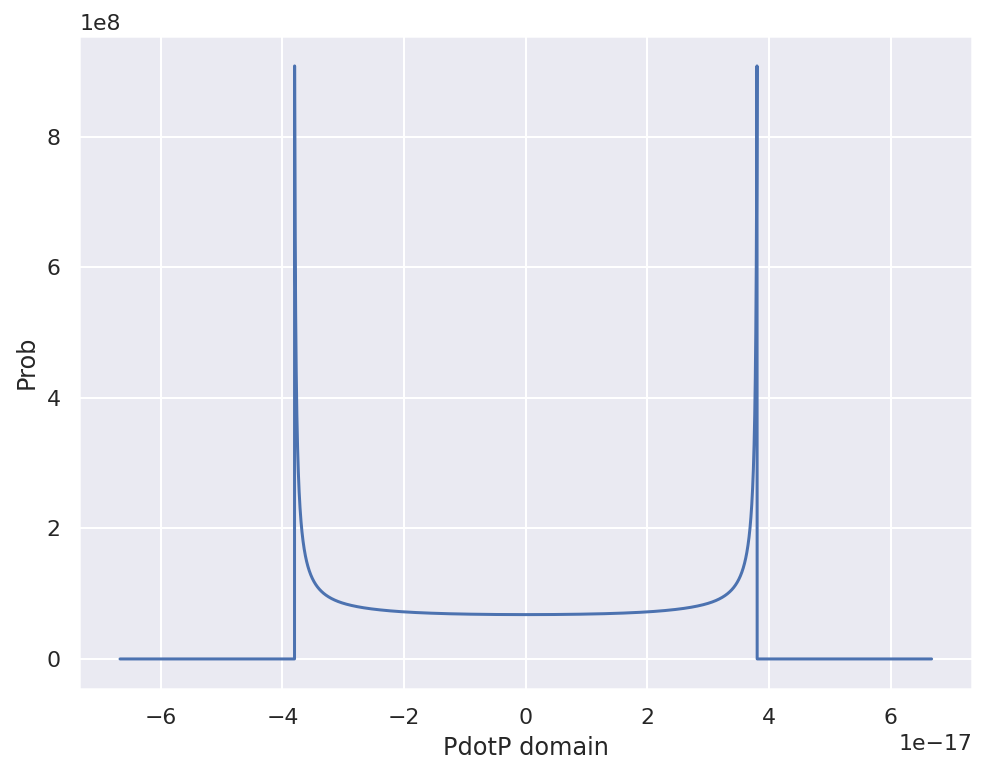

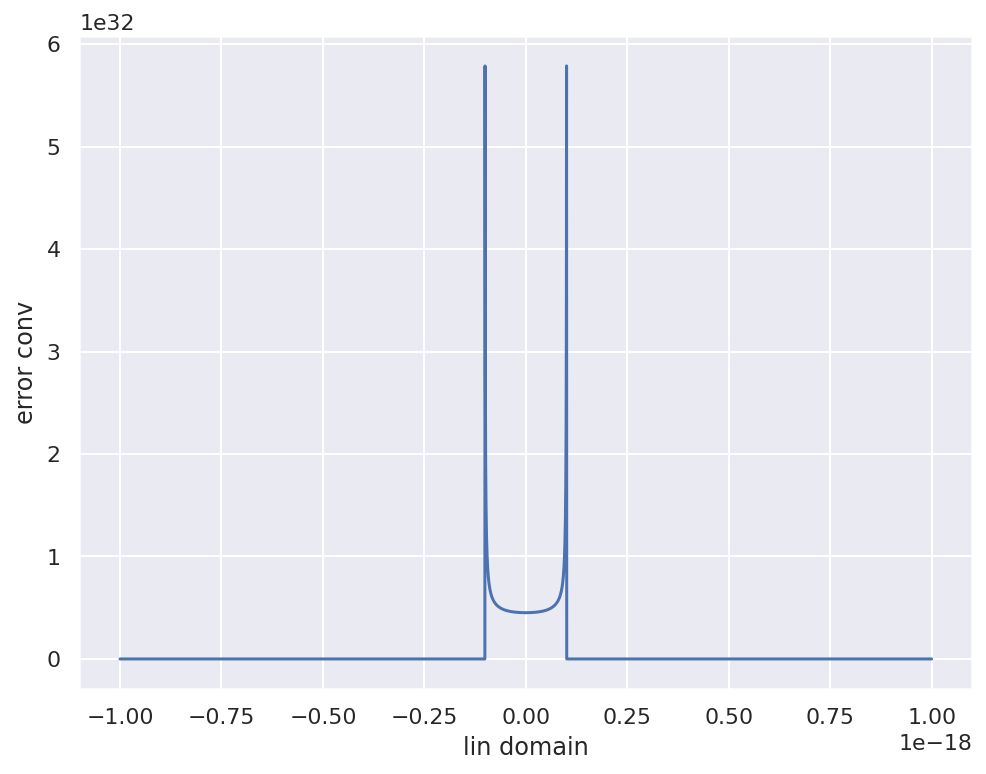

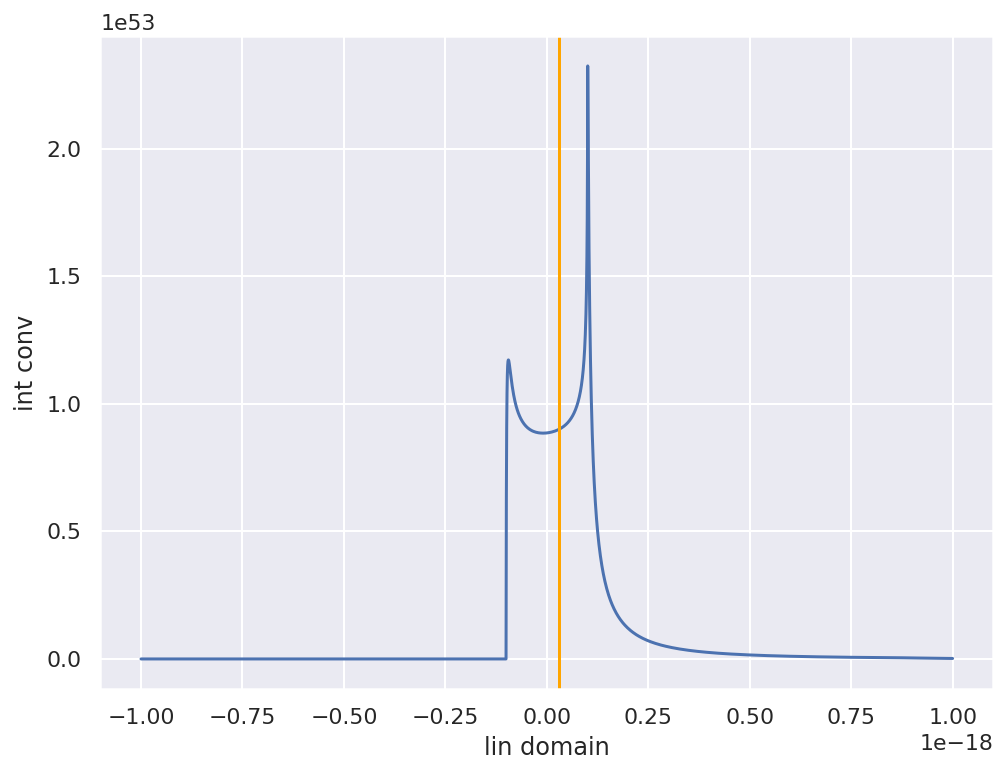

prob dist: <scipy.interpolate.interpolate.interp1d object at 0x7f3982afae00>


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


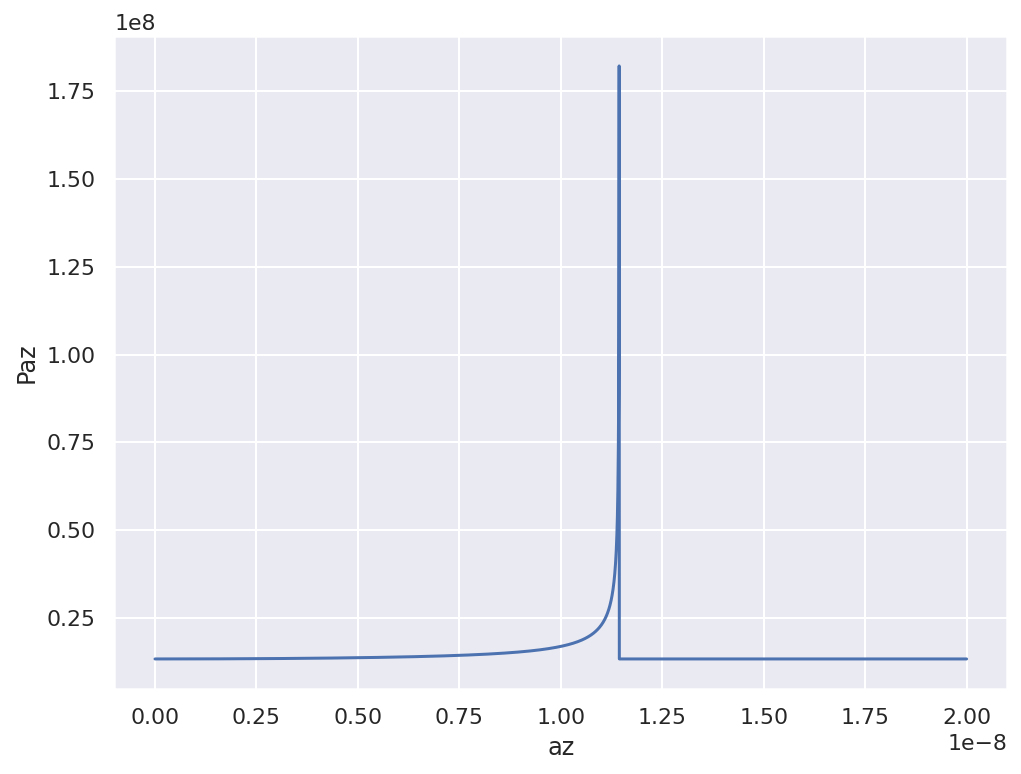

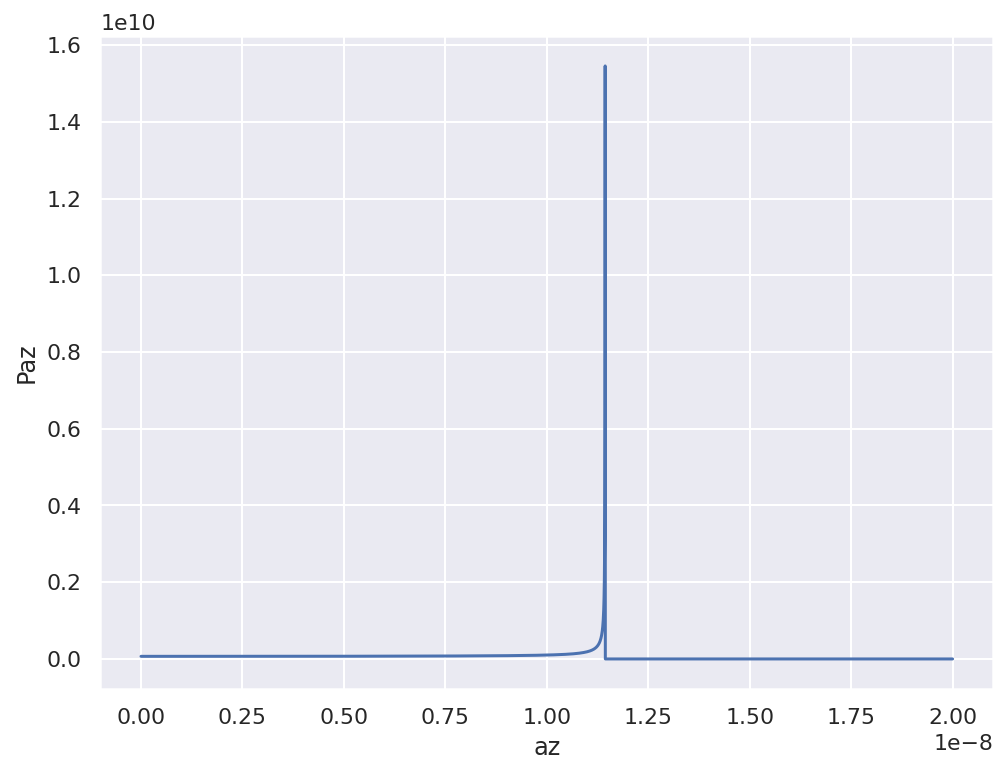

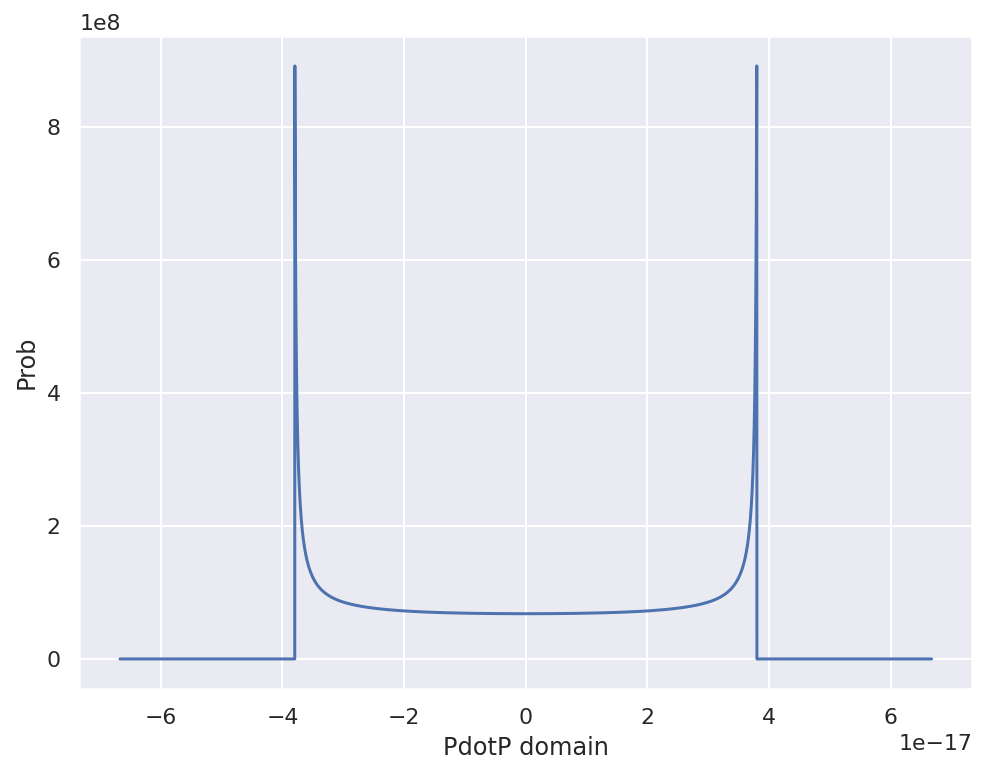

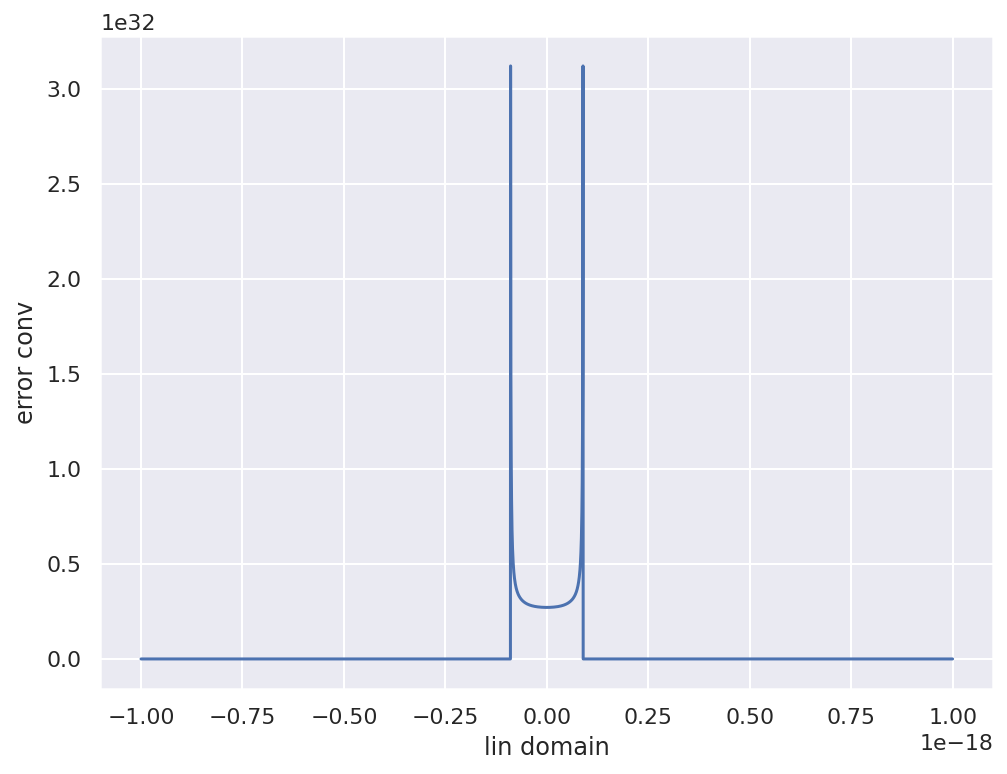

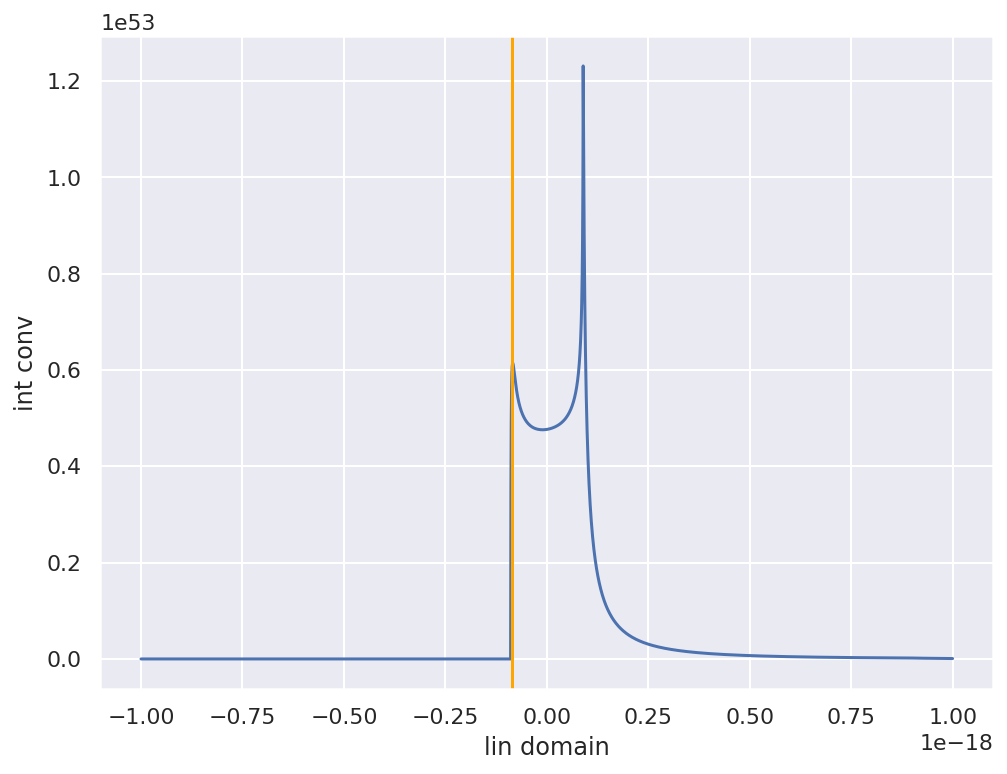

prob dist: <scipy.interpolate.interpolate.interp1d object at 0x7f3982a4ef40>


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


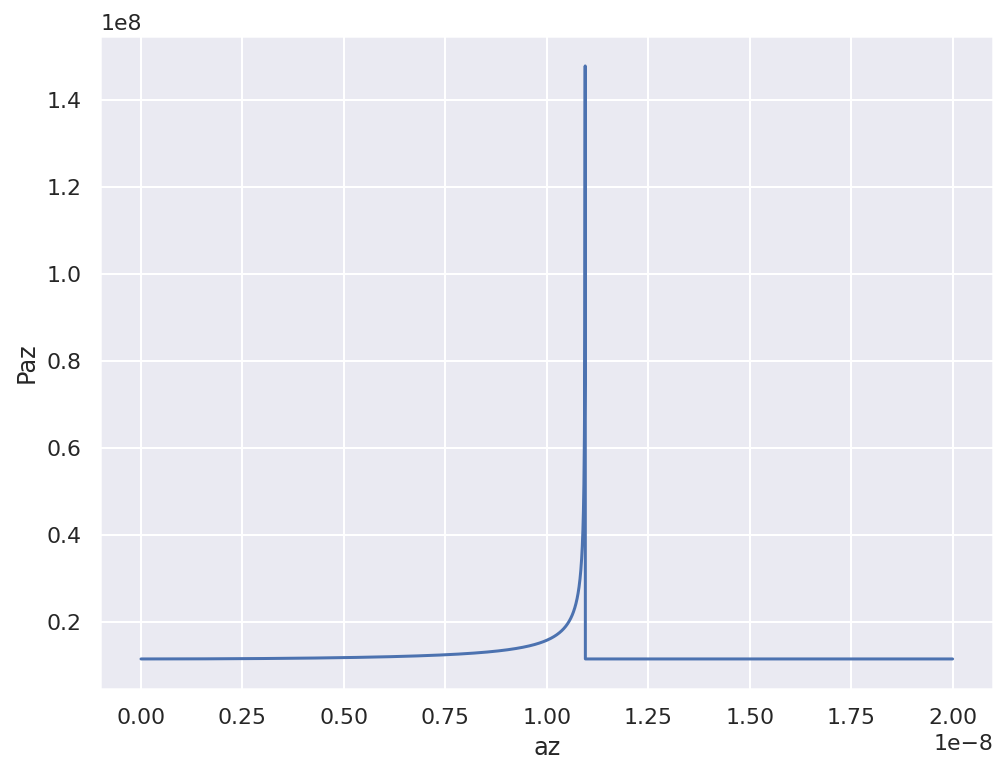

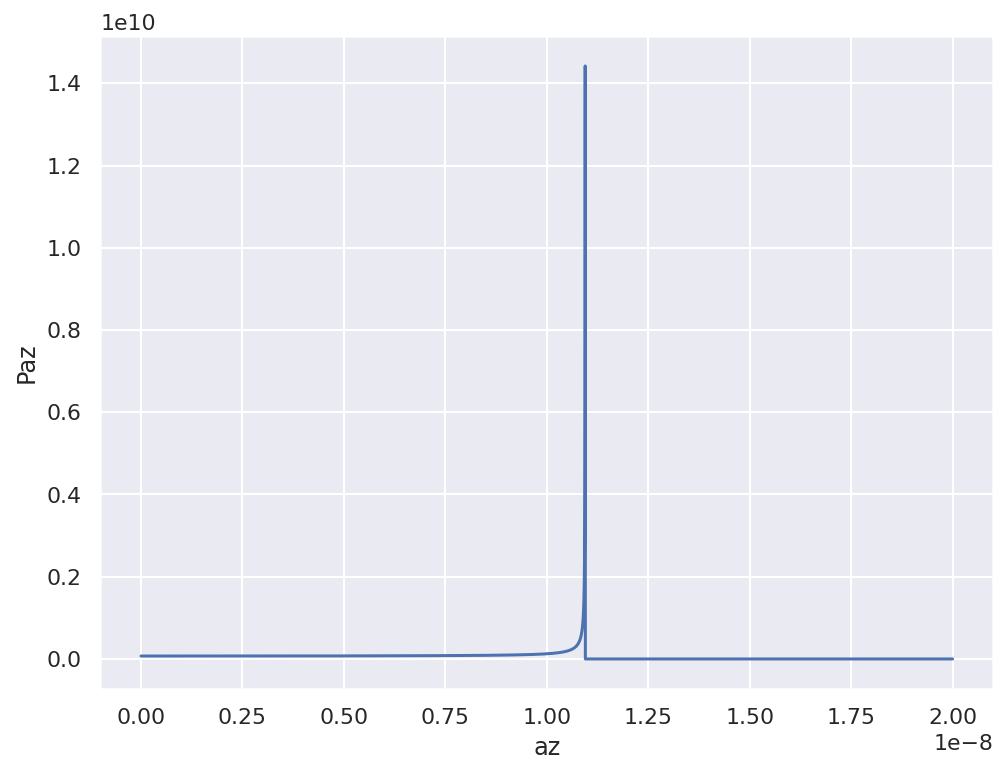

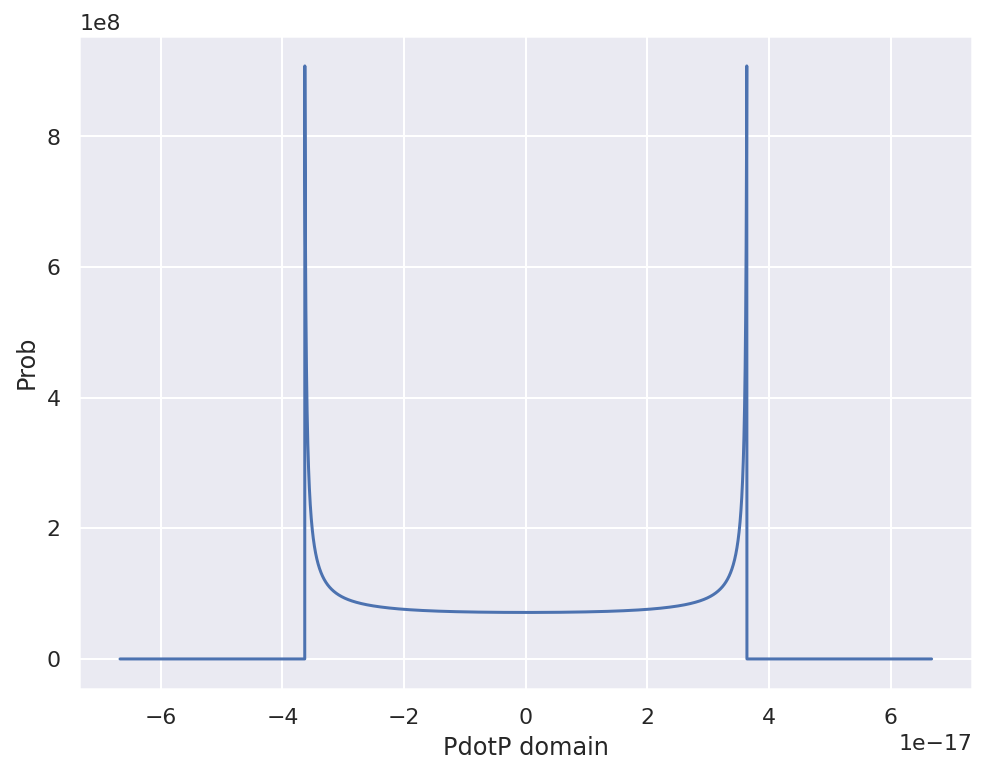

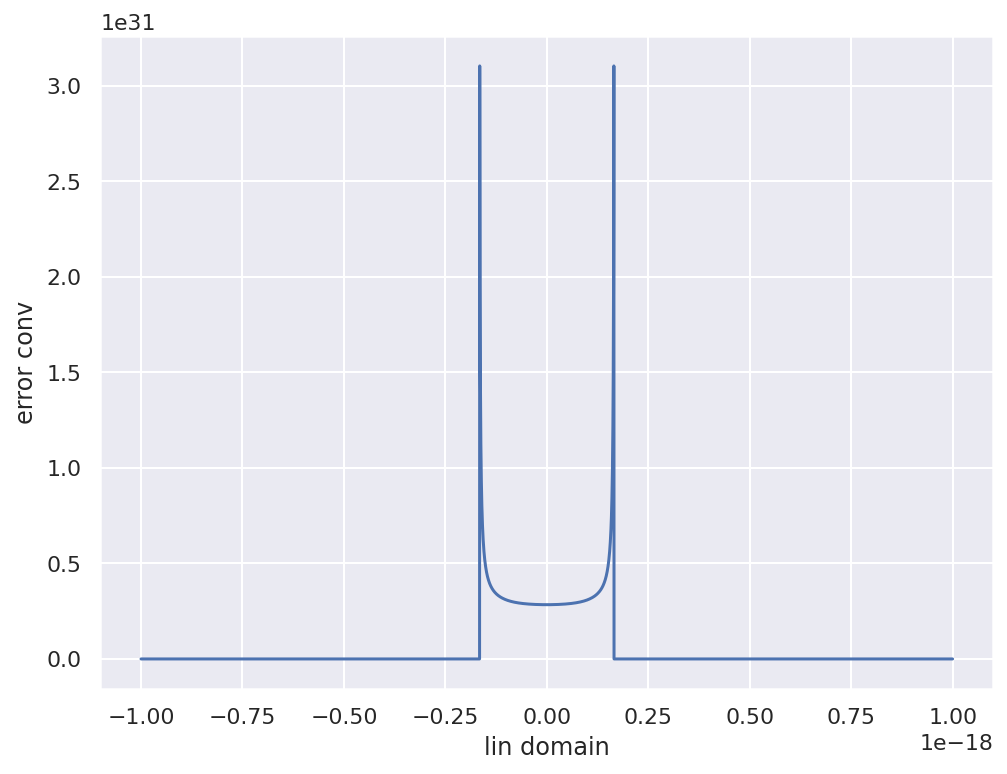

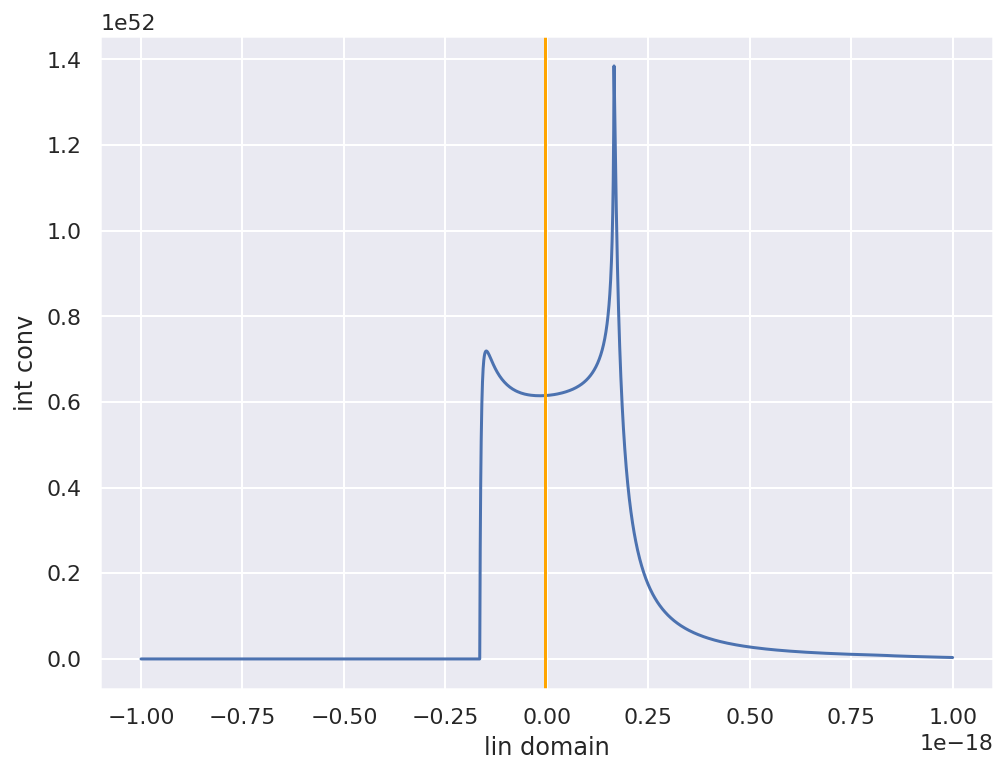

prob dist: <scipy.interpolate.interpolate.interp1d object at 0x7f39d3a284a0>


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


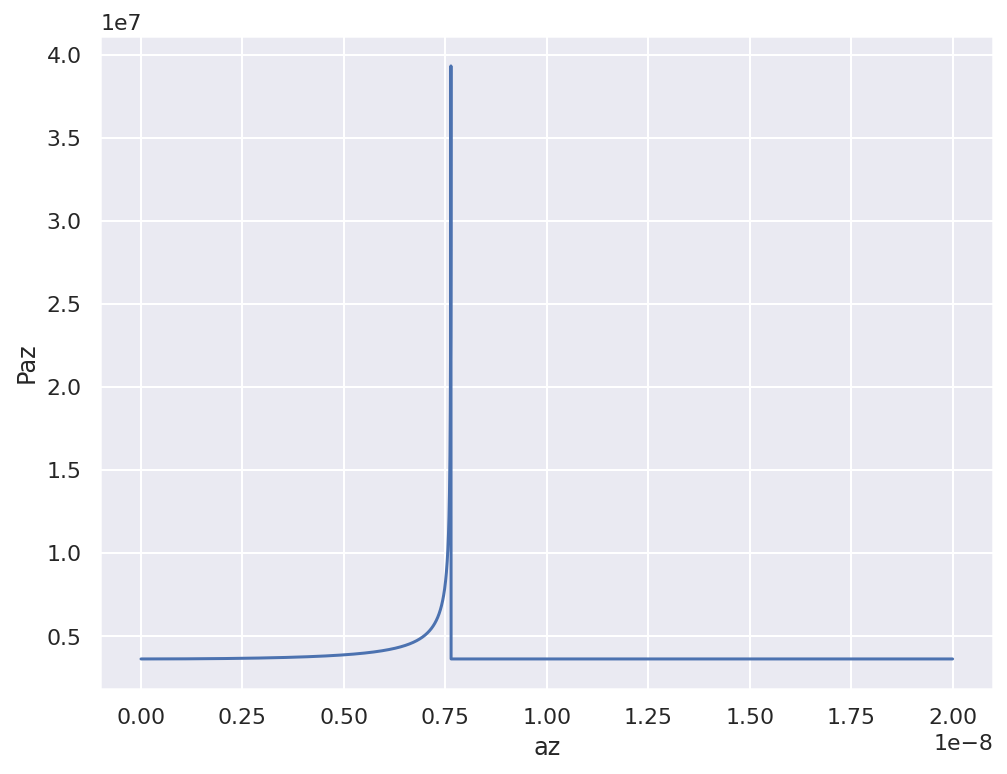

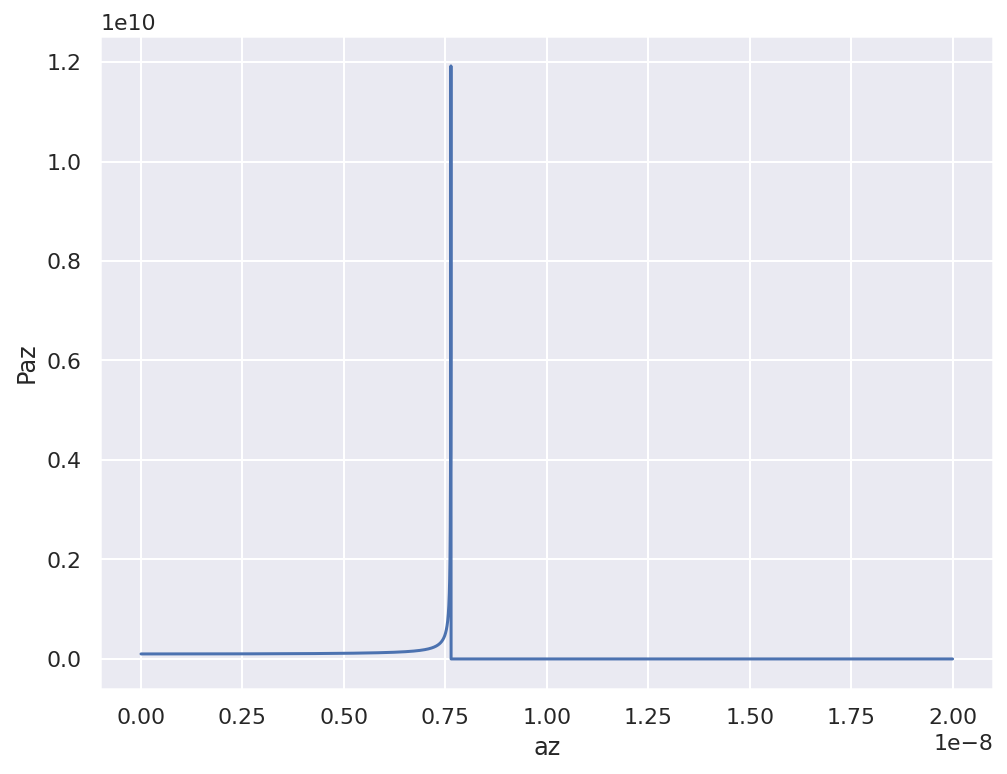

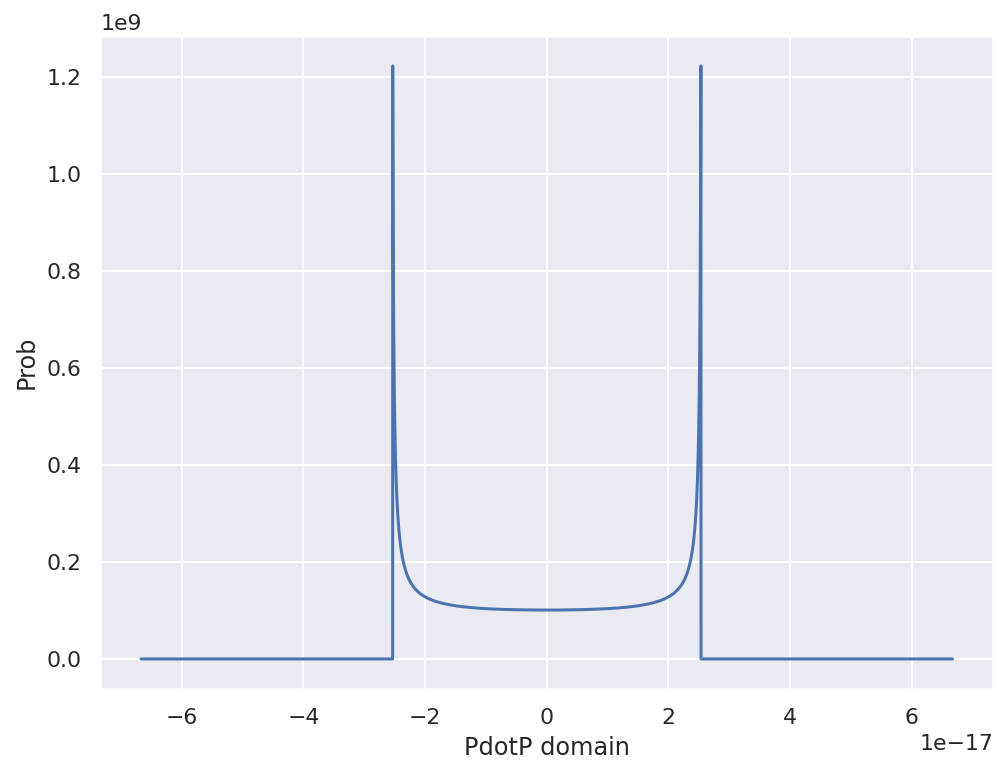

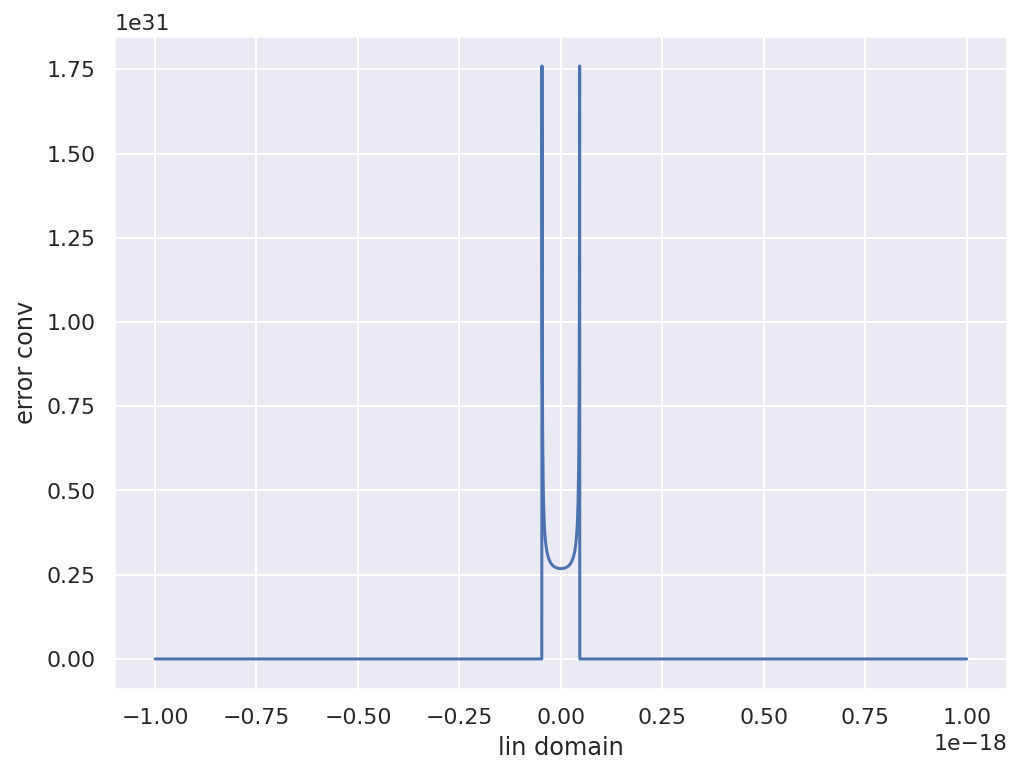

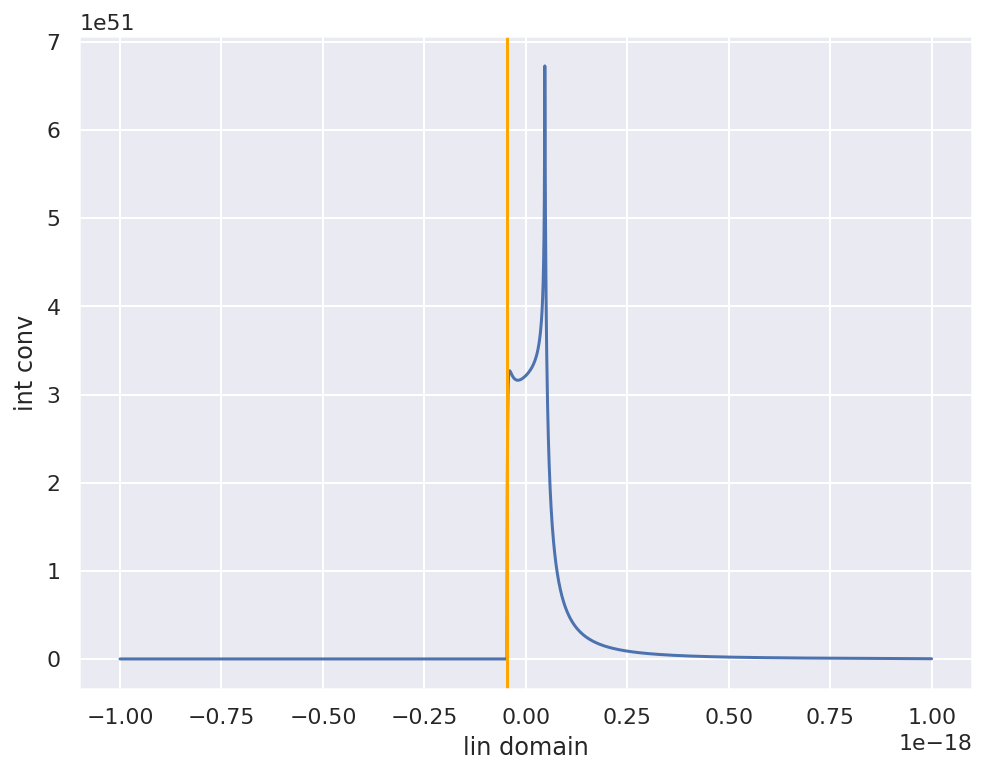

prob dist: <scipy.interpolate.interpolate.interp1d object at 0x7f39d354fea0>


/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


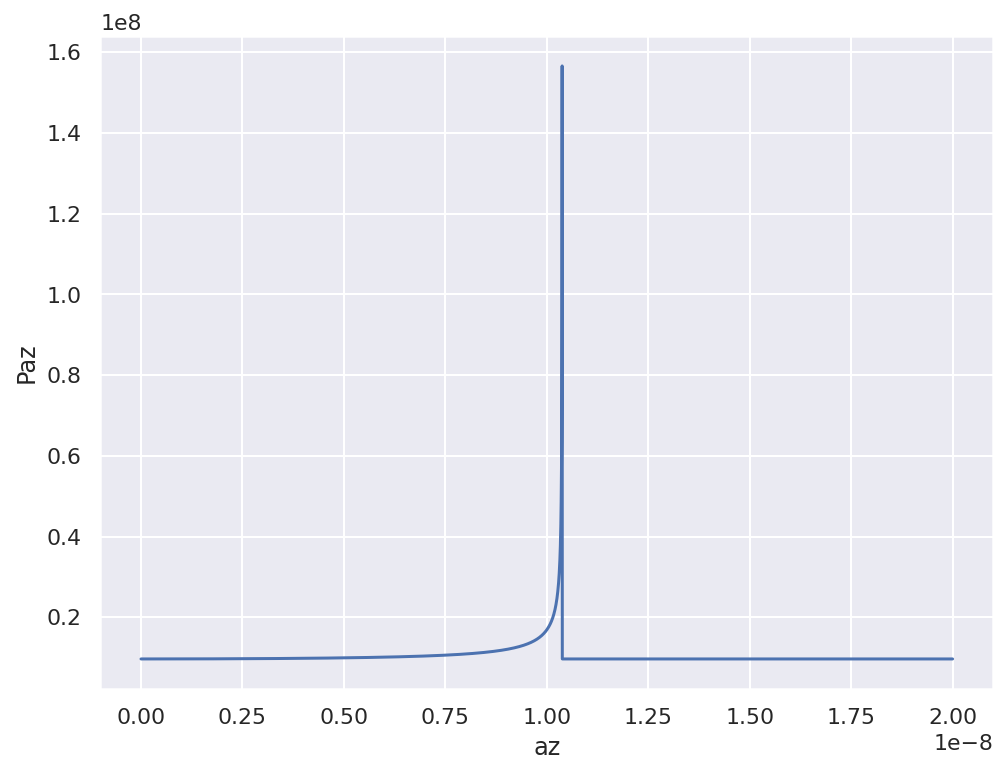

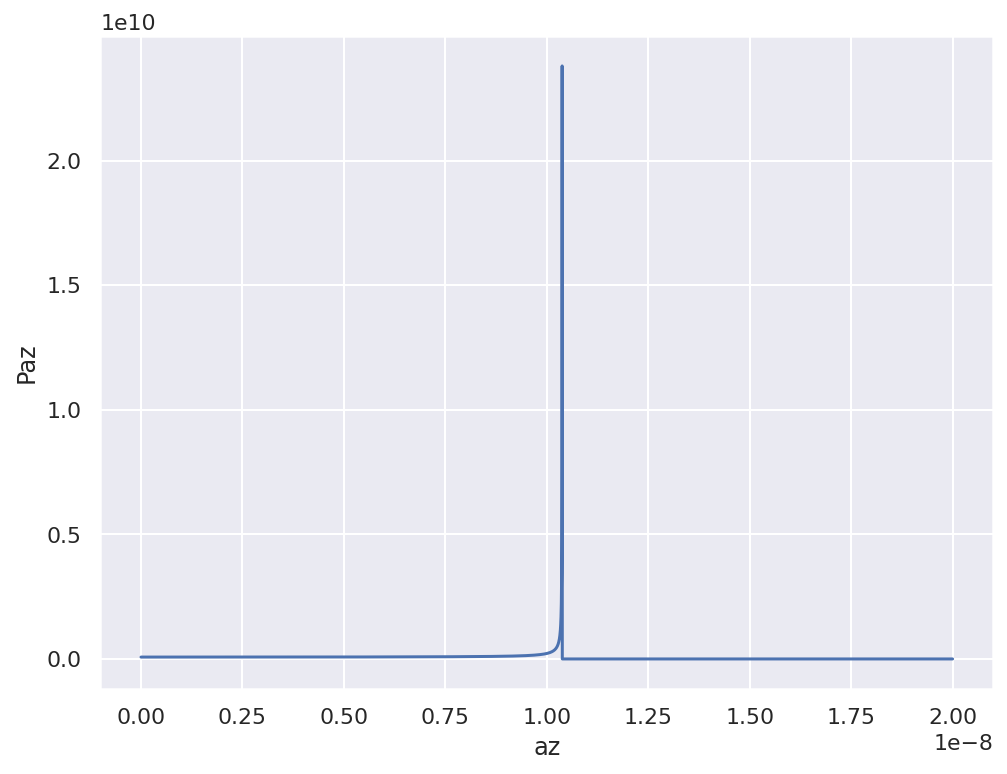

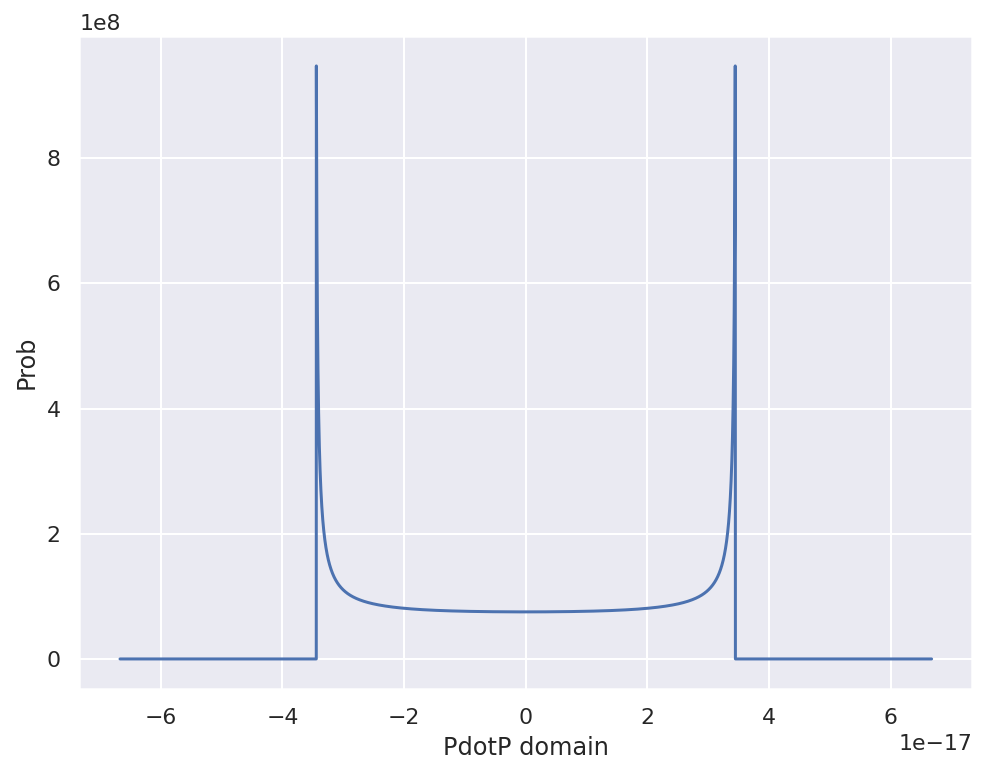

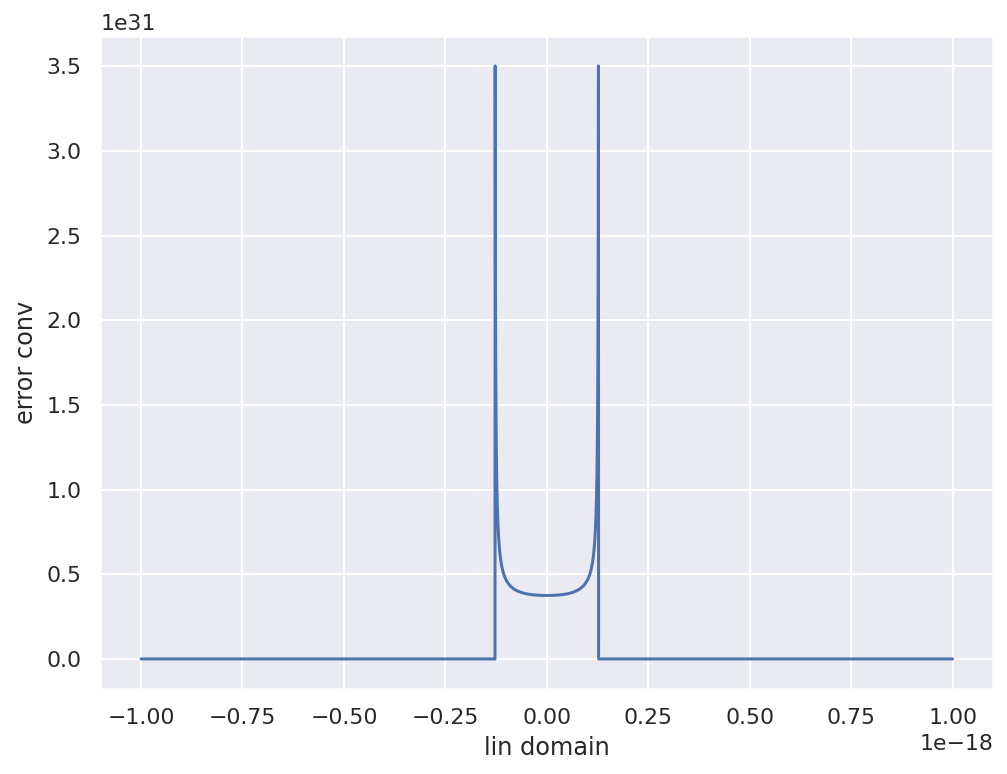

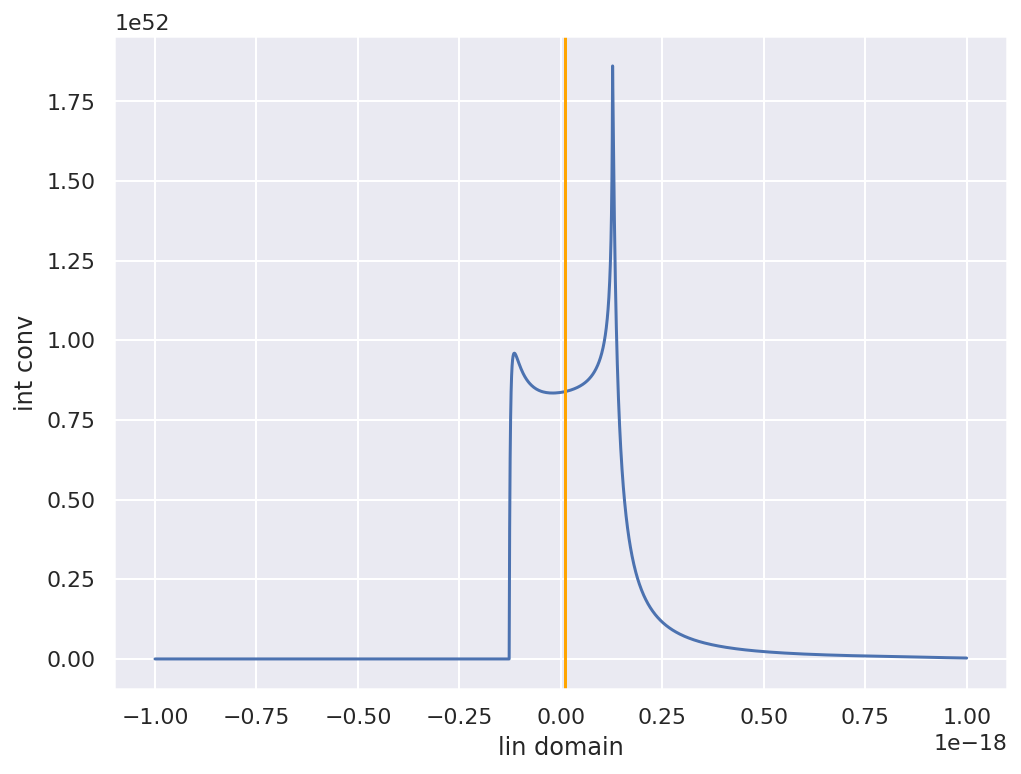

prob dist: <scipy.interpolate.interpolate.interp1d object at 0x7f39ca8d3db0>


554.2871062489345

In [20]:
likelihood_pulsar_spin(
    model=m,
    pulsars=pulsars,
    Pdot_kde=None,
    cluster_μ=-2.53,
    coords=(-44, 305),
    mass_bin=-1,
)